# Определение перспективного тарифа для телеком-компании

## Первый взгляд на данные

Посмотрим на наши таблицы в отдельности и подумаем, как их можно объединить.

In [1]:
import pandas as pd
import numpy as np
import math
from collections import defaultdict
import plotly.express as px
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats as st

pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#print(os.getcwd())

def open_file(filename, indexcol=None):
    path_home = './datasets/' + filename
    path_server = '/datasets/' + filename
    if os.path.exists(path_home):
        return pd.read_csv(path_home, index_col=indexcol)
    elif os.path.exists(path_server):
        return pd.read_csv(path_server, index_col=indexcol)
    elif os.path.exists(filename):
        return pd.read_csv(filename, index_col=indexcol)
    else:
        raise FileNotFoundError("cannot find file " + filename)

data_calls = open_file('calls.csv')
data_internet = open_file('internet.csv', 0)
data_messages = open_file('messages.csv')
data_tariffs = open_file('tariffs.csv')
data_users = open_file('users.csv')

In [3]:
data_calls.info()
data_calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
5  1000_5  2018-11-02      0.00     1000
6  1000_6  2018-10-18      0.00     1000
7  1000_7  2018-08-22     18.31     1000
8  1000_8  2018-09-15     18.44     1000
9  1000_9  2018-08-15      0.00     1000

В этом столбце вызывают некоторые вопросы звонки с длительностью 0. Но радует, что в данных нет пропусков.

In [4]:
data_internet.info()
data_internet.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000
5  1000_5   399.97   2018-10-02     1000
6  1000_6   540.08   2018-09-07     1000
7  1000_7   415.70   2018-07-11     1000
8  1000_8   505.40   2018-10-08     1000
9  1000_9   345.54   2018-09-03     1000

data_messages.info()
data_messages.head(10)

In [5]:
data_tariffs.info()
data_tariffs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra

In [6]:
data_users.info()
data_users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


user_id  age churn_date              city first_name  last_name  \
0     1000   52        NaN         Краснодар     Рафаил  Верещагин   
1     1001   41        NaN            Москва       Иван       Ежов   
2     1002   59        NaN       Стерлитамак    Евгений  Абрамович   
3     1003   23        NaN            Москва      Белла   Белякова   
4     1004   68        NaN       Новокузнецк    Татьяна   Авдеенко   
5     1005   67        NaN  Набережные Челны   Афанасий     Горлов   
6     1006   21        NaN         Ульяновск     Леонид   Ермолаев   
7     1007   65        NaN            Москва        Юна   Березина   
8     1008   63        NaN         Челябинск     Рустэм  Пономарёв   
9     1009   24        NaN             Пермь   Василиса    Блинова   

     reg_date tariff  
0  2018-05-25  ultra  
1  2018-11-01  smart  
2  2018-06-17  smart  
3  2018-08-17  ultra  
4  2018-05-14  ultra  
5  2018-01-25  smart  
6  2018-02-26  smart  
7  2018-04-19  smart  
8  2018-12-19  smart  
9  2018-03-22  smart

Так как данных во всех таблицах суммарно немного, есть смысл часть из них объединить. Опишем, как мы будем объединять таблицы:
* Таблицы calls, messages и internet нужно объединить в одну методом объединения строк. В объединенной таблице будут базовые столбцы - id пользователя и дата сессии. Столбца id не будет, так как во всех трех таблицах используется одинаковая индексация. Также будут столбцы:
    * _session_type_ - тип сущности строки (звонок, сообщение или интернет-сессия) 
    * _duration_ - параметр, который равен значению duration для строк из таблицы для звонков и NaN для строк для остальных двух таблиц
    * _mb_used_ - параметр, который равен значению _mb_used_ для строк из таблицы для сессий интернета и NaN для строк для остальных двух таблиц
* таблицы _users_ и _tariffs_ не будем сливать - вряд ли вся информация, которая хранится в них, нужна непосредственно в таблице транзакций, а дублирование данных будет значительным, и таблица увеличится по объему в 3-4 раза. Нужную информацию мы добавим по ходу дела в виде дополнительных столбцов.

Проверим также, что id операций во всех трех столбцах, которые мы хотим объединить, уникальны

In [7]:
print('Число уникальных значений в столбце data_calls:', data_calls['id'].nunique(), 'Число строк:', data_calls.shape[0])
print('Число уникальных значений в столбце data_messages:', data_messages['id'].nunique(), 'Число строк:', data_messages.shape[0])
print('Число уникальных значений в столбце data_internet:', data_internet['id'].nunique(), 'Число строк:', data_internet.shape[0])

Число уникальных значений в столбце data_calls: 202607 Число строк: 202607
Число уникальных значений в столбце data_messages: 123036 Число строк: 123036
Число уникальных значений в столбце data_internet: 149396 Число строк: 149396


Все хорошо. Тогда объединим таблицы (не забудем переименовать столбцы с временем операции - они по-разному называются в каждой из таблиц)

In [8]:
data_calls['session_type'] = 'CALL'
data_internet['session_type'] = 'INTERNET'
data_messages['session_type'] = 'MESSAGE'

data_calls.rename({'call_date': 'date'}, axis=1, inplace=True)
data_internet.rename({'session_date': 'date'}, axis=1, inplace=True)
data_messages.rename({'message_date': 'date'}, axis=1, inplace=True)

data = pd.concat([data_calls, data_internet, data_messages])

data.info()
data.head(10)
#data_internet.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475039 entries, 0 to 123035
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            475039 non-null  object 
 1   date          475039 non-null  object 
 2   duration      202607 non-null  float64
 3   user_id       475039 non-null  int64  
 4   session_type  475039 non-null  object 
 5   mb_used       149396 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 25.4+ MB


id        date  duration  user_id session_type  mb_used
0  1000_0  2018-07-25      0.00     1000         CALL      NaN
1  1000_1  2018-08-17      0.00     1000         CALL      NaN
2  1000_2  2018-06-11      2.85     1000         CALL      NaN
3  1000_3  2018-09-21     13.80     1000         CALL      NaN
4  1000_4  2018-12-15      5.18     1000         CALL      NaN
5  1000_5  2018-11-02      0.00     1000         CALL      NaN
6  1000_6  2018-10-18      0.00     1000         CALL      NaN
7  1000_7  2018-08-22     18.31     1000         CALL      NaN
8  1000_8  2018-09-15     18.44     1000         CALL      NaN
9  1000_9  2018-08-15      0.00     1000         CALL      NaN

### Вывод

Мы посмотрели на данные. Всего в нашем распоряжении было пять таблиц, три из которых мы объединили в одну. В получившейся таблице есть пропуски только в тех столбцах, которые создали мы - и по смыслу они не являются пропусками. В остальных данных пропусков нет. Из явных проблем с данными можно выявить только неправильный тип данных для дат (object вместо datetime). Остальные проблемы можно выявить только при детальном просмотре столбцов.

## Исправление ошибок в данных

В этом пункте мы сперва приведем даты к нужному типу, а затем посмотрим на данные в каждом столбце из двух полученных таблиц (в таблице с тарифами всего 14 значений, еще при первоначальном осмотре было понятно, что с ними все хорошо). Также сразу добавим столбцы с дополнительными данными в таблицы.

Для начала введем промежуточный словарь, который для каждого столбца будет хранить его описание из введения к проекту.

In [9]:
column_describe = []
column_describe.append({
    'date': 'дата звонка',
    'duration': 'длительность звонка в минутах',
    'user_id': 'идентификатор пользователя, сделавшего звонок',
    'mb_used': 'объём потраченного за сессию интернет-трафика (в мегабайтах)',
    'session_type': 'тип операции'
})
column_describe.append({
    'user_id': 'уникальный идентификатор пользователя',
    'first_name': 'имя пользователя',
    'last_name': 'фамилия пользователя',
    'age': 'возраст пользователя (годы)',
    'reg_date': 'дата подключения тарифа (день, месяц, год)',
    'churn_date': 'дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)',
    'city': 'город проживания пользователя',
    'tariff': 'название тарифного плана'
})

Определим также некоторые вспомогательные функции для получения полной информации о столбце

In [10]:
# базовая информация о каждом столбце
def print_base_info(col, data_ind):
    if data_ind == 0:
        cur_data = data
    else:
        cur_data = data_users
    print(column_describe[data_ind][col])
    print(cur_data[col].describe())
    print('Уникальных значений:', cur_data[col].value_counts().count())
    display(cur_data.sort_values(by=col, ascending=False).head(10))
    display(cur_data.sort_values(by=col, ascending=True).head(10))
    print('Количество дубликатов (уникальные значения):', cur_data.duplicated(subset=[col]).sum())
    print('Количество дубликатов (все значения):', cur_data.duplicated(subset=[col], keep=False).sum())
    print('Текущее число пропусков:', cur_data[col].isna().sum())
    print(100*cur_data[col].isna().sum()/cur_data[col].isna().count(), '%', sep='')
    
def print_na(col, cur_data=data):
    print('Текущее число пропусков:', cur_data[col].isna().sum())
    print(100*cur_data[col].isna().sum()/cur_data[col].isna().count(), '%', sep='')
    
# график для отображения количества пользователей по значениям определенных столбцов 
# (для столбцов с небольшим диапазоном значений)
def plotly_bar_plot_sorted_indexes(col, data_ind, title=''):
    if data_ind == 0:
        cur_data = data
    else:
        cur_data = data_users
    title = 'Зависимость количества пользователей от значений столбца ' + col if title == '' else title
    plot_data = cur_data[col].value_counts().sort_index().rename_axis('unique_values').reset_index(name='counts')
    plot = px.bar(plot_data, x='unique_values', y='counts', labels={'counts':'Количество', 'unique_values': column_describe[data_ind][col]}, title=title)
    plot.show()
    
def plotly_bar_plot_sorted_values(col, data_ind, title=''):
    if data_ind == 0:
        cur_data = data
    else:
        cur_data = data_users
    title = 'Зависимость количества пользователей от значений столбца ' + col if title == '' else title
    plot_data = cur_data[col].value_counts().sort_values(ascending=False).rename_axis('unique_values').reset_index(name='counts')
    plot = px.bar(plot_data, x='unique_values', y='counts', labels={'counts':'Количество', 'unique_values': column_describe[data_ind][col]}, title=title)
    plot.show()

# график для отображения количества пользователей по значениям определенных столбцов 
# (для столбцов с любым диапазоном значений)
def pandas_bar_plot(bins, col, data_ind, text='пользователей', data_cur=None):
    cur_data = None
    if data_cur is None:
        if data_ind == 0:
            cur_data = data
        else:
            cur_data = data_users
    else:
        cur_data = data_cur
    category_col = col + '_category'
    cur_data[category_col] = pd.cut(cur_data[col].to_list(), bins)
    plot_data = cur_data[category_col].value_counts().sort_index().rename_axis(category_col).reset_index(name='counts')
    
    print('Дисперсия:', cur_data[col].to_frame().var()[col])
    display(cur_data[col].to_frame().describe())
    
    title = 'Зависимость количества ' + text + ' от значений столбца ' + col
    plt = plot_data.plot(x=category_col, y='counts', kind='bar', title=title, grid=True, figsize=(15,8))
    plt.set_xlabel(column_describe[data_ind][col])
    plt.set_ylabel('Количество')
    
def month_plot(table, month_col='month', add_title_1='операций', add_title_2=''):
    if table == 0:
        cur_data=data
    elif table == 1:
        cur_data=data_users
    else:
        raise ValueError('incorrect first argument of function month_plot: it must be 0 or 1')
        
    title = 'Зависимость количества ' + add_title_1 + ' от значений столбца month ' + add_title_2
    plot_data = cur_data[month_col].value_counts().sort_index().rename_axis('unique_values').reset_index(name='counts')
    plot = px.bar(plot_data, x='unique_values', y='counts', labels={'counts':'Количество ' + add_title_1, 'unique_values': column_describe[table][month_col]}, title=title)

    plot.update_layout(
        xaxis = dict(
            tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        )
    )
    plot.show()
    
def day_of_week_plot(table, col, add_title_1='', add_title_2=''):
    if table == 0:
        cur_data = data
    elif table == 1:
        cur_data = data_users
    else:
        raise ValueError('incorrect first argument of function month_plot: it must be 0 or 1')
        
    title = 'Зависимость количества ' + add_title_1 + ' от значений столбца ' + col + ' ' + add_title_2
    plot_data = cur_data[col].value_counts().sort_index().rename_axis('unique_values').reset_index(name='counts')
    plot = px.bar(plot_data, x='unique_values', y='counts', labels={'counts':'Количество ' + add_title_1, 'unique_values': column_describe[table][col]}, title=title)

    plot.update_layout(
        xaxis = dict(
            tickvals = [0, 1, 2, 3, 4, 5, 6],
            ticktext = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        )
    )

    plot.show()

### Преобразование типов данных

In [11]:
data['date'] = pd.to_datetime(data['date'])
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'])
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], errors='coerce')
data.info()
data_users.info()
data_users.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475039 entries, 0 to 123035
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            475039 non-null  object        
 1   date          475039 non-null  datetime64[ns]
 2   duration      202607 non-null  float64       
 3   user_id       475039 non-null  int64         
 4   session_type  475039 non-null  object        
 5   mb_used       149396 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 25.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   fir

user_id  age churn_date         city first_name  last_name   reg_date  \
0     1000   52        NaT    Краснодар     Рафаил  Верещагин 2018-05-25   
1     1001   41        NaT       Москва       Иван       Ежов 2018-11-01   
2     1002   59        NaT  Стерлитамак    Евгений  Абрамович 2018-06-17   
3     1003   23        NaT       Москва      Белла   Белякова 2018-08-17   
4     1004   68        NaT  Новокузнецк    Татьяна   Авдеенко 2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra

### Исправление ошибок в таблице _data_users_

#### Столбец _reg_date_

In [12]:
print_base_info('reg_date', 1)

дата подключения тарифа (день, месяц, год)
count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object
Уникальных значений: 270


user_id  age churn_date             city first_name   last_name  \
336     1336   27        NaT              Уфа  Авксентий  Алексеичев   
258     1258   52        NaT  Санкт-Петербург    Валерий      Беляев   
140     1140   22        NaT            Киров     Леонид   Ахматулин   
74      1074   68        NaT           Якутск     Андрей     Кравцов   
445     1445   40        NaT           Москва      Рауль      Иванов   
485     1485   34        NaT            Киров     Таисия      Сухова   
371     1371   50 2018-12-30             Омск     Ириней    Трофимов   
278     1278   46        NaT      Новокузнецк     Леонид    Троицкий   
95      1095   70        NaT      Новосибирск   Марианна    Кабанова   
236     1236   30        NaT           Москва       Леон     Демидов   

      reg_date tariff  
336 2018-12-31  ultra  
258 2018-12-31  smart  
140 2018-12-31  smart  
74  2018-12-30  smart  
445 2018-12-29  smart  
485 2018-12-29  ultra  
371 2018-12-25  smart  
278 2018-12-23  smart  
95  2018-12-23  smart  
236 2018-12-22  smart

user_id  age churn_date        city  first_name  last_name   reg_date  \
453     1453   50        NaT      Москва      Кузьма   Акуленко 2018-01-01   
193     1193   55        NaT      Тамбов       Арсен   Безруков 2018-01-01   
55      1055   39        NaT      Казань       Луиза   Березина 2018-01-02   
155     1155   71        NaT  Ставрополь   Александр     Чернов 2018-01-02   
375     1375   53        NaT       Пенза       Мария  Акимычева 2018-01-04   
204     1204   18        NaT      Москва   Мирослава   Лазарева 2018-01-04   
32      1032   31        NaT   Ульяновск        Инна  Игнатьева 2018-01-04   
254     1254   75 2018-08-17      Москва  Александра   Сухарева 2018-01-04   
308     1308   52        NaT      Москва      Инесса  Корнилова 2018-01-04   
433     1433   71        NaT    Подольск     Клариса   Алёшкова 2018-01-05   

    tariff  
453  ultra  
193  smart  
55   smart  
155  smart  
375  ultra  
204  smart  
32   smart  
254  ultra  
308  smart  
433  smart

Количество дубликатов (уникальные значения): 230
Количество дубликатов (все значения): 372
Текущее число пропусков: 0
0.0%


Как видим, наши данные представлены целиком за 2018й год (с 1 января по 31 декабря).
Создадим столбцы с месяцем и днем недели регистрации.

In [13]:
data_users['reg_day_of_week'] = data_users['reg_date'].dt.dayofweek
column_describe[1]['reg_day_of_week'] = 'день недели регистрации'
data_users['reg_month'] = data_users['reg_date'].dt.month
column_describe[1]['reg_month'] = 'месяц регистрации'

In [14]:
day_of_week_plot(1, 'reg_day_of_week', 'зарегистрированных пользователей', '')

In [15]:
month_plot(1, 'reg_month', 'регистраций', '')

Данные по месяцам и дням недели выглядят равномерно, каких-то очевидных проблем с данными нет

Также посмотрим общее распределение по датам

In [16]:
plotly_bar_plot_sorted_indexes('reg_date', 1)

Каждый день у компании появлялось от 0 до 8 новых клиентов.

#### Столбец _churn_date_

In [17]:
print_base_info('churn_date', 1)

дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
count                      38
unique                     33
top       2018-12-03 00:00:00
freq                        2
first     2018-08-17 00:00:00
last      2018-12-30 00:00:00
Name: churn_date, dtype: object
Уникальных значений: 33


user_id  age churn_date          city first_name   last_name   reg_date  \
371     1371   50 2018-12-30          Омск     Ириней    Трофимов 2018-12-25   
64      1064   55 2018-12-26        Якутск     Динара     Алфеева 2018-03-17   
399     1399   31 2018-12-25           Уфа      Алиса    Абрашина 2018-11-06   
438     1438   24 2018-12-24  Екатеринбург    Нателла    Бородина 2018-10-05   
128     1128   51 2018-12-23      Волжский     Ксения      Агаева 2018-12-15   
242     1242   39 2018-12-21     Хабаровск      Радим    Федосеев 2018-11-18   
422     1422   60 2018-12-21        Москва      Клара    Устинова 2018-10-12   
206     1206   35 2018-12-20        Москва      Елена    Шарапова 2018-11-03   
20      1020   59 2018-12-18          Чита       Тала     Костина 2018-10-22   
163     1163   21 2018-12-16        Москва        Лев  Вишневский 2018-11-03   

    tariff  reg_day_of_week  reg_month  
371  smart                1         12  
64   smart                5          3  
399  ultra                1         11  
438  smart                4         10  
128  ultra                5         12  
242  smart                6         11  
422  smart                4         10  
206  smart                5         11  
20   smart                0         10  
163  smart                5         11

user_id  age churn_date              city  first_name   last_name  \
254     1254   75 2018-08-17            Москва  Александра    Сухарева   
71      1071   20 2018-08-31              Омск      Гектор     Чумаков   
255     1255   40 2018-09-02           Саранск    Серафима  Пономарева   
480     1480   29 2018-09-26       Новокузнецк      Гелена  Емельянова   
392     1392   54 2018-09-27         Челябинск        Алла    Беликова   
50      1050   44 2018-10-03            Тюмень      Рузана    Аничкина   
191     1191   64 2018-10-03  Набережные Челны   Александр   Акиндинов   
265     1265   24 2018-10-04              Омск       Радим      Адамов   
19      1019   63 2018-10-05             Томск     Игнатий     Круглов   
51      1051   37 2018-10-14            Москва    Кристина      Сомова   

      reg_date tariff  reg_day_of_week  reg_month  
254 2018-01-04  ultra                3          1  
71  2018-01-09  smart                1          1  
255 2018-02-19  ultra                0          2  
480 2018-02-14  smart                2          2  
392 2018-02-27  ultra                1          2  
50  2018-06-16  ultra                5          6  
191 2018-06-30  smart                5          6  
265 2018-06-24  ultra                6          6  
19  2018-05-16  ultra                2          5  
51  2018-05-28  smart                0          5

Количество дубликатов (уникальные значения): 466
Количество дубликатов (все значения): 472
Текущее число пропусков: 462
92.4%


Данные представлены за 2018й год (с 17 августа по 30 декабря).
Создадим столбцы с месяцем и днем недели прекращения пользования тарифом и посмотрим на графики распределения этих величин

In [18]:
data_users['churn_day_of_week'] = data_users['churn_date'].dt.dayofweek
column_describe[1]['churn_day_of_week'] = 'день недели регистрации'
data_users['churn_month'] = data_users['churn_date'].dt.month
column_describe[1]['churn_month'] = 'месяц регистрации'

In [19]:
day_of_week_plot(1, 'churn_day_of_week', 'прекращений использования тарифа', '')

In [20]:
month_plot(1, 'churn_month', 'прекращений использования тарифа', '')

Наблюдается увеличение числа прекращений пользователем использования тарифа (такая хитрая формулировка - способ отразить тот факт, что, возможно, одни и те же пользователи могут прекращать пользоваться одним тарифом, начиная при этом пользоваться другим - этот факт нам еще предстоит проверить). Вкупе с тем, что первый пользователь, отказавшийся от своего тарифа, появился только в августе, хотя данные о появившихся клиентах есть с января, такие данные - нормальная ситуация, если где-то в конце 2017го оба исследуемых тарифа только появились. Если же это не так, то мы имеем дело с некоторыми потерями в данных об окончании использования тарифа клиентом. Гипотезу о времени создания тарифов в конце 2017го мы проверить никак не можем, ибо спросить не у кого, как заполнить пропуски, если она неверна - тоже неясно. Потому будем считать, что гипотеза является верной.

Также посмотрим общее распределение по датам

In [21]:
plotly_bar_plot_sorted_indexes('churn_date', 1)

Каждый день от 0 до 2 клиентов отказывались от своих тарифов.

#### Столбец _city_

In [22]:
print_base_info('city', 1)

город проживания пользователя
count        500
unique        76
top       Москва
freq          99
Name: city, dtype: object
Уникальных значений: 76


user_id  age churn_date       city first_name   last_name   reg_date  \
472     1472   53        NaT  Ярославль      Наида     Боброва 2018-01-18   
39      1039   40        NaT  Ярославль    Агнесса   Андреенко 2018-06-21   
198     1198   26        NaT  Ярославль     Эдуард      Швецов 2018-08-15   
64      1064   55 2018-12-26     Якутск     Динара     Алфеева 2018-03-17   
147     1147   63        NaT     Якутск   Владимир     Синицын 2018-07-09   
74      1074   68        NaT     Якутск     Андрей     Кравцов 2018-12-30   
306     1306   21        NaT       Чита      Радим       Попов 2018-11-30   
113     1113   52        NaT       Чита    Харитон    Булгаков 2018-01-24   
20      1020   59 2018-12-18       Чита       Тала     Костина 2018-10-22   
131     1131   36        NaT       Чита       Нина  Афонасьева 2018-12-08   

    tariff  reg_day_of_week  reg_month  churn_day_of_week  churn_month  
472  smart                3          1                NaN          NaN  
39   ultra                3          6                NaN          NaN  
198  smart                2          8                NaN          NaN  
64   smart                5          3                2.0         12.0  
147  smart                0          7                NaN          NaN  
74   smart                6         12                NaN          NaN  
306  smart                4         11                NaN          NaN  
113  smart                2          1                NaN          NaN  
20   smart                0         10                1.0         12.0  
131  smart                5         12                NaN          NaN

user_id  age churn_date         city first_name     last_name   reg_date  \
135     1135   64        NaT  Архангельск     Милена      Воронина 2018-01-29   
253     1253   29        NaT    Астрахань       Алла  Масленникова 2018-08-06   
66      1066   47        NaT    Астрахань       Исак       Малахов 2018-06-24   
280     1280   53        NaT    Астрахань    Артемий       Худяков 2018-07-18   
423     1423   50        NaT    Астрахань       Леон         Силин 2018-01-23   
320     1320   38        NaT     Балашиха      Рубен       Киселёв 2018-09-10   
263     1263   32        NaT     Балашиха    Ермолай        Зайцев 2018-04-30   
207     1207   57        NaT     Балашиха        Яна      Зеленина 2018-08-12   
322     1322   45        NaT     Балашиха  Александр     Сальников 2018-09-09   
455     1455   38        NaT     Балашиха      Рубен     Авринский 2018-03-22   

    tariff  reg_day_of_week  reg_month  churn_day_of_week  churn_month  
135  smart                0          1                NaN          NaN  
253  ultra                0          8                NaN          NaN  
66   smart                6          6                NaN          NaN  
280  smart                2          7                NaN          NaN  
423  smart                1          1                NaN          NaN  
320  smart                0          9                NaN          NaN  
263  smart                0          4                NaN          NaN  
207  smart                6          8                NaN          NaN  
322  smart                6          9                NaN          NaN  
455  ultra                3          3                NaN          NaN

Количество дубликатов (уникальные значения): 424
Количество дубликатов (все значения): 495
Текущее число пропусков: 0
0.0%


Преобразуем все буквы городов в заглавные и посмотрим на уникальные значения

In [23]:
data_users['city'] = data_users['city'].str.upper()
data_users['city'].value_counts().head(40)

МОСКВА              99
САНКТ-ПЕТЕРБУРГ     39
НОВОСИБИРСК         16
ОМСК                14
КАЗАНЬ              14
УФА                 12
КРАСНОДАР           11
НАБЕРЕЖНЫЕ ЧЕЛНЫ    11
УЛЬЯНОВСК           11
ЕКАТЕРИНБУРГ        11
ЧЕЛЯБИНСК            9
САМАРА               9
НИЖНИЙ НОВГОРОД      8
ВОЛГОГРАД            8
ПЕРМЬ                8
УЛАН-УДЭ             7
НОВОКУЗНЕЦК          7
ВОЛОГДА              7
КРАСНОЯРСК           7
СОЧИ                 6
ИРКУТСК              6
РОСТОВ-НА-ДОНУ       6
ТЮМЕНЬ               6
ПЕНЗА                6
КИРОВ                6
ТОМСК                6
ВОРОНЕЖ              6
ВЛАДИВОСТОК          5
СТАВРОПОЛЬ           5
МАХАЧКАЛА            5
БАЛАШИХА             5
МАГНИТОГОРСК         5
ТОЛЬЯТТИ             4
САРАНСК              4
НОВОРОССИЙСК         4
КОСТРОМА             4
АСТРАХАНЬ            4
ПЕТРОЗАВОДСК         4
ХАБАРОВСК            4
ЧИТА                 4
Name: city, dtype: int64

Визуально дубликатов нет. Москва и Санкт-Петербург, ожидаемо, самые популярные.

#### Столбец _tariff_

In [24]:
print_base_info('tariff', 1)

название тарифного плана
count       500
unique        2
top       smart
freq        351
Name: tariff, dtype: object
Уникальных значений: 2


user_id  age churn_date              city first_name    last_name  \
0       1000   52        NaT         КРАСНОДАР     Рафаил    Верещагин   
156     1156   63        NaT  НАБЕРЕЖНЫЕ ЧЕЛНЫ    Валерий       Галкин   
382     1382   42        NaT            САМАРА     Оксана    Нестерова   
381     1381   64        NaT            МОСКВА     Тамара  Серебрякова   
380     1380   45        NaT    РОСТОВ-НА-ДОНУ   Доминика     Карасева   
379     1379   39        NaT            МОСКВА      Нелли    Кочергина   
165     1165   19        NaT            САМАРА    Алексей     Медведев   
166     1166   48        NaT   НИЖНИЙ НОВГОРОД  Святослав       Жданов   
167     1167   30        NaT          КЕМЕРОВО    Клавдия     Абдулина   
168     1168   28        NaT          КОСТРОМА      Лилия     Ананьева   

      reg_date tariff  reg_day_of_week  reg_month  churn_day_of_week  \
0   2018-05-25  ultra                4          5                NaN   
156 2018-11-12  ultra                0         11                NaN   
382 2018-03-26  ultra                0          3                NaN   
381 2018-01-13  ultra                5          1                NaN   
380 2018-05-07  ultra                0          5                NaN   
379 2018-08-09  ultra                3          8                NaN   
165 2018-10-14  ultra                6         10                NaN   
166 2018-08-17  ultra                4          8                NaN   
167 2018-09-29  ultra                5          9                NaN   
168 2018-01-24  ultra                2          1                NaN   

     churn_month  
0            NaN  
156          NaN  
382          NaN  
381          NaN  
380          NaN  
379          NaN  
165          NaN  
166          NaN  
167          NaN  
168          NaN

user_id  age churn_date             city first_name  last_name  \
249     1249   25        NaT            КУРСК    Изольда   Авдушева   
302     1302   43        NaT              УФА  Владислав    Абаимов   
301     1301   26        NaT        МАХАЧКАЛА      Наида  Авраменко   
299     1299   37        NaT              УФА   Мариетта   Симонова   
298     1298   29        NaT      НОВОСИБИРСК    Надежда  Чеснокова   
297     1297   66        NaT          ИРКУТСК      Радим   Абрамцев   
296     1296   60        NaT           МОСКВА    Альфред     Черный   
295     1295   19        NaT        КРАСНОДАР      Олеся     Зимина   
293     1293   39 2018-11-22  САНКТ-ПЕТЕРБУРГ      Эдита   Дубинина   
291     1291   73        NaT           МОСКВА    Мануэла   Анищенко   

      reg_date tariff  reg_day_of_week  reg_month  churn_day_of_week  \
249 2018-08-14  smart                1          8                NaN   
302 2018-01-23  smart                1          1                NaN   
301 2018-09-27  smart                3          9                NaN   
299 2018-01-27  smart                5          1                NaN   
298 2018-07-26  smart                3          7                NaN   
297 2018-12-04  smart                1         12                NaN   
296 2018-06-05  smart                1          6                NaN   
295 2018-09-19  smart                2          9                NaN   
293 2018-09-05  smart                2          9                3.0   
291 2018-02-08  smart                3          2                NaN   

     churn_month  
249          NaN  
302          NaN  
301          NaN  
299          NaN  
298          NaN  
297          NaN  
296          NaN  
295          NaN  
293         11.0  
291          NaN

Количество дубликатов (уникальные значения): 498
Количество дубликатов (все значения): 500
Текущее число пропусков: 0
0.0%


В этом столбце всего два уникальных значения - больше тут проверять нечего.

#### Столбец _age_

In [25]:
print_base_info('age', 1)

возраст пользователя (годы)
count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64
Уникальных значений: 58


user_id  age churn_date             city  first_name      last_name  \
219     1219   75        NaT            КИРОВ      Кузьма       Некрасов   
436     1436   75        NaT           МОСКВА       Радим        Ерофеев   
478     1478   75        NaT          ГРОЗНЫЙ       Таира  Константинова   
356     1356   75        NaT           МОСКВА     Евгений       Гончаров   
177     1177   75        NaT      НОВОСИБИРСК      Лолита       Аничкина   
254     1254   75 2018-08-17           МОСКВА  Александра       Сухарева   
463     1463   74        NaT  САНКТ-ПЕТЕРБУРГ       Ринат      Авринский   
123     1123   74        NaT        КРАСНОДАР    Вениамин        Устинов   
216     1216   74        NaT        ВОЛГОГРАД      Рустам        Малинин   
364     1364   74        NaT     ЕКАТЕРИНБУРГ    Мстислав     Алексеенко   

      reg_date tariff  reg_day_of_week  reg_month  churn_day_of_week  \
219 2018-01-21  smart                6          1                NaN   
436 2018-04-04  ultra                2          4                NaN   
478 2018-07-16  smart                0          7                NaN   
356 2018-04-18  ultra                2          4                NaN   
177 2018-06-19  smart                1          6                NaN   
254 2018-01-04  ultra                3          1                4.0   
463 2018-11-16  ultra                4         11                NaN   
123 2018-03-18  smart                6          3                NaN   
216 2018-11-23  smart                4         11                NaN   
364 2018-08-29  ultra                2          8                NaN   

     churn_month  
219          NaN  
436          NaN  
478          NaN  
356          NaN  
177          NaN  
254          8.0  
463          NaN  
123          NaN  
216          NaN  
364          NaN

user_id  age churn_date           city first_name  last_name   reg_date  \
77      1077   18        NaT         МОСКВА     Марица   Кольцова 2018-10-23   
204     1204   18        NaT         МОСКВА  Мирослава   Лазарева 2018-01-04   
270     1270   18        NaT  НИЖНЕВАРТОВСК   Мальвина  Вешнякова 2018-07-01   
268     1268   18        NaT         МОСКВА     Трофим     Трошин 2018-05-28   
473     1473   18        NaT     КРАСНОЯРСК    Николай    Лебедев 2018-08-05   
403     1403   18        NaT         БРЯНСК      Ахмет     Амелин 2018-05-20   
247     1247   19        NaT         МОСКВА       Адам    Тарасов 2018-05-23   
419     1419   19        NaT   НОВОРОССИЙСК    Эльмира      Яшина 2018-07-19   
195     1195   19        NaT         МОСКВА   Веселина   Петухова 2018-10-14   
226     1226   19        NaT    НОВОСИБИРСК     Альбин    Бобылёв 2018-06-01   

    tariff  reg_day_of_week  reg_month  churn_day_of_week  churn_month  
77   smart                1         10                NaN          NaN  
204  smart                3          1                NaN          NaN  
270  ultra                6          7                NaN          NaN  
268  smart                0          5                NaN          NaN  
473  ultra                6          8                NaN          NaN  
403  ultra                6          5                NaN          NaN  
247  smart                2          5                NaN          NaN  
419  smart                3          7                NaN          NaN  
195  smart                6         10                NaN          NaN  
226  ultra                4          6                NaN          NaN

Количество дубликатов (уникальные значения): 442
Количество дубликатов (все значения): 500
Текущее число пропусков: 0
0.0%


Возраст пользователей - от 18 до 75 лет, средний возраст - 46.6 лет. Никаких видимых проблем в этом столбце не наблюдается.

#### Столбец _user_id_

In [26]:
print_base_info('user_id', 1)

уникальный идентификатор пользователя
count     500.000000
mean     1249.500000
std       144.481833
min      1000.000000
25%      1124.750000
50%      1249.500000
75%      1374.250000
max      1499.000000
Name: user_id, dtype: float64
Уникальных значений: 500


user_id  age churn_date             city first_name   last_name  \
499     1499   35        NaT            ПЕРМЬ     Гектор    Корнилов   
498     1498   68 2018-10-25      ВЛАДИКАВКАЗ   Всеволод     Акимчин   
497     1497   32        NaT        ЧЕЛЯБИНСК   Каролина      Агеева   
496     1496   36        NaT          ВОЛОГДА     Трифон      Блохин   
495     1495   65        NaT          ИРКУТСК  Авксентий       Фокин   
494     1494   62        NaT             ОМСК      Ренат    Андропов   
493     1493   71        NaT       КРАСНОЯРСК     Таисия  Ахматулина   
492     1492   63        NaT  САНКТ-ПЕТЕРБУРГ    Руслана   Артёменко   
491     1491   56        NaT        ЧЕЛЯБИНСК   Радислав   Андрейкин   
490     1490   30        NaT           МОСКВА    Радомир      Алесин   

      reg_date tariff  reg_day_of_week  reg_month  churn_day_of_week  \
499 2018-09-27  smart                3          9                NaN   
498 2018-07-19  smart                3          7                3.0   
497 2018-10-09  smart                1         10                NaN   
496 2018-01-27  smart                5          1                NaN   
495 2018-08-28  ultra                1          8                NaN   
494 2018-08-17  smart                4          8                NaN   
493 2018-11-24  ultra                5         11                NaN   
492 2018-06-26  smart                1          6                NaN   
491 2018-04-25  ultra                2          4                NaN   
490 2018-04-03  smart                1          4                NaN   

     churn_month  
499          NaN  
498         10.0  
497          NaN  
496          NaN  
495          NaN  
494          NaN  
493          NaN  
492          NaN  
491          NaN  
490          NaN

user_id  age churn_date              city first_name  last_name   reg_date  \
0     1000   52        NaT         КРАСНОДАР     Рафаил  Верещагин 2018-05-25   
1     1001   41        NaT            МОСКВА       Иван       Ежов 2018-11-01   
2     1002   59        NaT       СТЕРЛИТАМАК    Евгений  Абрамович 2018-06-17   
3     1003   23        NaT            МОСКВА      Белла   Белякова 2018-08-17   
4     1004   68        NaT       НОВОКУЗНЕЦК    Татьяна   Авдеенко 2018-05-14   
5     1005   67        NaT  НАБЕРЕЖНЫЕ ЧЕЛНЫ   Афанасий     Горлов 2018-01-25   
6     1006   21        NaT         УЛЬЯНОВСК     Леонид   Ермолаев 2018-02-26   
7     1007   65        NaT            МОСКВА        Юна   Березина 2018-04-19   
8     1008   63        NaT         ЧЕЛЯБИНСК     Рустэм  Пономарёв 2018-12-19   
9     1009   24        NaT             ПЕРМЬ   Василиса    Блинова 2018-03-22   

  tariff  reg_day_of_week  reg_month  churn_day_of_week  churn_month  
0  ultra                4          5                NaN          NaN  
1  smart                3         11                NaN          NaN  
2  smart                6          6                NaN          NaN  
3  ultra                4          8                NaN          NaN  
4  ultra                0          5                NaN          NaN  
5  smart                3          1                NaN          NaN  
6  smart                0          2                NaN          NaN  
7  smart                3          4                NaN          NaN  
8  smart                2         12                NaN          NaN  
9  smart                3          3                NaN          NaN

Количество дубликатов (уникальные значения): 0
Количество дубликатов (все значения): 0
Текущее число пропусков: 0
0.0%


Дубликатов в данных нет, что ведет к выводу - клиенты, которые отказывались от тарифа, либо не переходили на новые тарифы, либо получали другой уникальный _user_id_. Мы не можем достоверно проверить второй вариант, так как имени, фамилии, возраста и города для этого формально недостаточно (серия и номер паспорта давали бы более корректную оценку), но мы можем проверить его хотя бы с теми данными, что есть

In [27]:
data_users.groupby(['age', 'first_name', 'last_name'])['user_id'].count()

age  first_name  last_name    
18   Ахмет       Амелин           1
     Мальвина    Вешнякова        1
     Марица      Кольцова         1
     Мирослава   Лазарева         1
     Николай     Лебедев          1
                                 ..
75   Евгений     Гончаров         1
     Кузьма      Некрасов         1
     Лолита      Аничкина         1
     Радим       Ерофеев          1
     Таира       Константинова    1
Name: user_id, Length: 500, dtype: int64

Так как количество строк после группировки равно количеству уникальных _user_id_, можно говорить о том, что пользователи, отказывавшиеся от своего тарифа, уходили навсегда. Ну или помимо тарифа они меняли имя/фамилию/город.

### Исправление ошибок в таблице _data_

#### Столбец _user_id_

In [28]:
print_base_info('user_id', 0)

идентификатор пользователя, сделавшего звонок
count    475039.000000
mean       1254.151352
std         144.213371
min        1000.000000
25%        1130.000000
50%        1260.000000
75%        1380.000000
max        1499.000000
Name: user_id, dtype: float64
Уникальных значений: 498


id       date  duration  user_id session_type  mb_used
123035  1499_183 2018-11-16       NaN     1499      MESSAGE      NaN
149267   1499_28 2018-12-27       NaN     1499     INTERNET   146.27
149276   1499_37 2018-11-11       NaN     1499     INTERNET     0.00
149275   1499_36 2018-11-07       NaN     1499     INTERNET   505.25
149274   1499_35 2018-10-17       NaN     1499     INTERNET   825.10
149273   1499_34 2018-10-27       NaN     1499     INTERNET     0.00
149272   1499_33 2018-12-16       NaN     1499     INTERNET   273.27
149271   1499_32 2018-10-29       NaN     1499     INTERNET     0.00
149270   1499_31 2018-11-23       NaN     1499     INTERNET   209.34
149269   1499_30 2018-11-30       NaN     1499     INTERNET   114.45

id       date  duration  user_id session_type  mb_used
0      1000_0 2018-07-25       0.0     1000         CALL      NaN
256  1000_256 2018-06-18       NaN     1000      MESSAGE      NaN
257  1000_257 2018-08-09       NaN     1000      MESSAGE      NaN
258  1000_258 2018-05-25       NaN     1000      MESSAGE      NaN
259  1000_259 2018-06-20       NaN     1000      MESSAGE      NaN
260  1000_260 2018-08-31       NaN     1000      MESSAGE      NaN
261  1000_261 2018-11-23       NaN     1000      MESSAGE      NaN
262  1000_262 2018-12-04       NaN     1000      MESSAGE      NaN
263  1000_263 2018-10-02       NaN     1000      MESSAGE      NaN
255  1000_255 2018-08-28       NaN     1000      MESSAGE      NaN

Количество дубликатов (уникальные значения): 474541
Количество дубликатов (все значения): 475039
Текущее число пропусков: 0
0.0%


Проверим, что множество значений столбца _user_id_ в таблице data является подмножеством множества значений столбца _user_id_ в таблице data_users (в противном случае у нас будут данные о звонках/сообщениях/интернет-сессиях для неизвестных пользователей).

In [29]:
set(data['user_id']) - set(data_users['user_id'])

set()

Все хорошо.

In [30]:
set(data_users['user_id']) - set(data['user_id'])

{1128, 1371}

Однако, что интересно, у нас есть пользователи, о которых есть данные о том, что они являлись в некоторый отрезок времени клиентами Мегалайна, однако не сделали ни одного звонка, ни отправили ни одного сообщения и ни разу не попытались выйти в интернет. Возможно, Bellingcat и The Insider смогли бы что-то рассказать нам о подобных товарищах и их звонках (а если им позвонить и представиться начальником, они в чем-нибудь признаются), но мы все-таки будем считать, что эти клиенты действительно не пользовались услугами (хотя и оплачивали). Например, они использовали сим-карту Мегалайна как запасную.

#### Столбец _date_

In [31]:
print_base_info('date', 0)

дата звонка
count                  475039
unique                    365
top       2018-12-31 00:00:00
freq                     3351
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: date, dtype: object
Уникальных значений: 365


id       date  duration  user_id session_type  mb_used
113542  1291_168 2018-12-31      4.28     1291         CALL      NaN
110147   1445_52 2018-12-31       NaN     1445      MESSAGE      NaN
110141   1445_46 2018-12-31       NaN     1445      MESSAGE      NaN
110139   1445_44 2018-12-31       NaN     1445      MESSAGE      NaN
110135   1445_40 2018-12-31       NaN     1445      MESSAGE      NaN
37613    1131_43 2018-12-31       NaN     1131     INTERNET   121.34
110129   1445_34 2018-12-31       NaN     1445      MESSAGE      NaN
110128   1445_33 2018-12-31       NaN     1445      MESSAGE      NaN
110126   1445_31 2018-12-31       NaN     1445      MESSAGE      NaN
131477    1437_3 2018-12-31       NaN     1437     INTERNET   608.01

id       date  duration  user_id session_type  mb_used
181903  1453_1095 2018-01-01      5.63     1453         CALL      NaN
180968   1453_160 2018-01-01      0.00     1453         CALL      NaN
181106   1453_298 2018-01-01     15.25     1453         CALL      NaN
135277   1453_498 2018-01-01       NaN     1453     INTERNET   209.31
135081   1453_302 2018-01-01       NaN     1453     INTERNET   794.96
76907    1193_169 2018-01-01     13.29     1193         CALL      NaN
181239   1453_431 2018-01-01     19.92     1453         CALL      NaN
57584    1193_123 2018-01-01       NaN     1193     INTERNET     0.00
36021    1155_410 2018-01-02       NaN     1155      MESSAGE      NaN
112561   1453_586 2018-01-02       NaN     1453      MESSAGE      NaN

Количество дубликатов (уникальные значения): 474674
Количество дубликатов (все значения): 475039
Текущее число пропусков: 0
0.0%


Как видим, наши данные представлены целиком за 2018й год (с 1 января по 31 декабря).

Добавим также отдельно столбцы с месяцем и днем недели. Год нам не нужен - он везде 2018й.

In [32]:
data['day_of_week'] = data['date'].dt.dayofweek
column_describe[0]['day_of_week'] = 'день недели операции'
data['month'] = data['date'].dt.month
column_describe[0]['month'] = 'месяц операции'

Посмотрим на распределение полученных величин

In [33]:
title = 'Зависимость количества операций от значений столбца day_of_week'
plot_data = data['day_of_week'].value_counts().sort_index().rename_axis('unique_values').reset_index(name='counts')
plot = px.bar(plot_data, x='unique_values', y='counts', labels={'counts':'Количество операций', 'unique_values': column_describe[0]['day_of_week']}, title=title)

plot.update_layout(
    xaxis = dict(
        tickvals = [0, 1, 2, 3, 4, 5, 6],
        ticktext = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    )
)

plot.show()

In [34]:
month_plot(0, 'month', 'операций', '')

График для дней недели выглядит реалистичным, чего не скажешь о графике по месяцам - он выглядит как прямая возрастающая линия от января к декабрю. Попробуем детальнее посмотреть на график по месяцам.

In [35]:
def month_plot_2(cur_data=data, add_title1='операций', add_title_2=''):
    title = 'Зависимость количества ' + add_title1 + ' от значений столбца month ' + add_title_2
    plot_data = cur_data['month'].value_counts().sort_index().rename_axis('unique_values').reset_index(name='counts')
    plot = px.bar(plot_data, x='unique_values', y='counts', labels={'counts':'Количество операций', 'unique_values': column_describe[0]['month']}, title=title)

    plot.update_layout(
        xaxis = dict(
            tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        )
    )
    plot.show()


month_plot_2(data[data['session_type'] == 'CALL'], 'по звонкам', '')
month_plot_2(data[data['session_type'] == 'MESSAGE'], 'по сообщениям', '')
month_plot_2(data[data['session_type'] == 'INTERNET'], 'по интернет-сессиям', '')

month_plot_2(data[(data['session_type'] == 'CALL') & (data['duration'] > 0)], 'по звонкам (без учета непринятых)', '')
month_plot_2(data[(data['session_type'] == 'INTERNET') & (data['mb_used'] > 0)], 'по интернет-сессиям (без учета сессий с нулевым траффиком)', '')

Все графики также возрастающие. Такое поведение хорошо согласуется информацией, полученной при просмотре распределений дат подключения и отключения тарифов - ежемесячно много клиентов прибывало и мало убывало. Построим график дельты прибывших клиентов по месяцам 2018го года, а также график общего прироста, где в каждом месяце будет показываться, насколько больше подключений 

In [36]:
reg = data_users.groupby('reg_month')['user_id'].count()
churn = (data_users.groupby('churn_month')['user_id'].count() + pd.Series([0]*12, index=range(1,13))).fillna(0)
overall = (reg - churn).astype(int)
    
plot = px.bar(overall.rename_axis('unique_values').reset_index(name='counts'), 
              x='unique_values', y='counts', labels={'counts':'Количество операций', 'unique_values': 'Месяц'}, 
              title='Ежемесячный приток количества подключений')

plot.update_layout(
    xaxis = dict(
        tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
)
plot.show()

In [37]:
overall_count = overall
for i in overall_count.index[1:]:
    overall_count[i] += overall_count[i-1]
    
plot = px.bar(overall_count.rename_axis('unique_values').reset_index(name='counts'), 
              x='unique_values', y='counts', labels={'counts':'Количество операций', 'unique_values': 'Месяц'}, 
              title='Превышение количества подключений над количеством подключений на момент 1 января 2018 года')

plot.update_layout(
    xaxis = dict(
        tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
)
plot.show()

Посмотрим на корреляцию общей дельты клиентов по сравнению с началом года и количества действий в месяц

In [38]:
data['month'].value_counts().sort_index().corr(overall_count)

0.9959564804644238

Так как коэффициент корреляции большой, наши данные хорошо согласуются друг с другом. С каждым месяцем становится все больше и больше клиентов, и пропорционально с ростом количества клиентов растет и количество совершаемых клиентами действий.

Проверим также еще одну вещь - является ли _reg_date_ для каждого конкретного пользователя более ранней датой, чем дата любого его действия, и является ли _churn_date_ для каждого конкретного пользователя более поздней датой, чем дата любого его действия (если _churn_date_ задано, конечно).

In [39]:
# чуть сложный код, потому что в data_users больше user_id, чем в data
(data.groupby('user_id')['date'].min() >= 
 data_users[data_users['user_id'].isin(data['user_id'])].set_index('user_id')['reg_date']).all()

True

In [40]:
(data.groupby('user_id')['date'].max() <= 
 pd.to_datetime(data_users[data_users['user_id'].isin(data['user_id'])].set_index('user_id')['churn_date'].fillna('2018-12-31'))).all()

True

Все даты корректны.

#### Столбец _duration_

In [41]:
print_base_info('duration', 0)

длительность звонка в минутах
count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64
Уникальных значений: 2871


id       date  duration  user_id session_type  mb_used  \
95088    1241_44 2018-09-06     38.00     1241         CALL      NaN   
178737   1446_22 2018-11-07     37.35     1446         CALL      NaN   
5865     1017_61 2018-11-13     36.47     1017         CALL      NaN   
39777   1099_150 2018-08-14     36.12     1099         CALL      NaN   
60889   1153_135 2018-11-16     35.95     1153         CALL      NaN   
60747   1152_444 2018-06-25     35.13     1152         CALL      NaN   
100841    1260_5 2018-12-28     34.53     1260         CALL      NaN   
73168   1184_142 2018-09-26     34.52     1184         CALL      NaN   
81767   1203_340 2018-06-05     34.46     1203         CALL      NaN   
64283    1165_31 2018-11-16     34.25     1165         CALL      NaN   

        day_of_week  month  
95088             3      9  
178737            2     11  
5865              1     11  
39777             1      8  
60889             4     11  
60747             0      6  
100841            4     12  
73168             2      9  
81767             1      6  
64283             4     11

id       date  duration  user_id session_type  mb_used  \
0         1000_0 2018-07-25       0.0     1000         CALL      NaN   
57375   1145_206 2018-07-06       0.0     1145         CALL      NaN   
57380   1145_211 2018-09-25       0.0     1145         CALL      NaN   
57381   1145_212 2018-04-23       0.0     1145         CALL      NaN   
157627  1391_108 2018-11-28       0.0     1391         CALL      NaN   
157624  1391_105 2018-10-14       0.0     1391         CALL      NaN   
57386   1145_217 2018-07-14       0.0     1145         CALL      NaN   
57387   1145_218 2018-12-18       0.0     1145         CALL      NaN   
57390   1145_221 2018-10-12       0.0     1145         CALL      NaN   
57392   1145_223 2018-04-17       0.0     1145         CALL      NaN   

        day_of_week  month  
0                 2      7  
57375             4      7  
57380             1      9  
57381             0      4  
157627            2     11  
157624            6     10  
57386             5      7  
57387             1     12  
57390             4     10  
57392             1      4

Количество дубликатов (уникальные значения): 472167
Количество дубликатов (все значения): 474812
Текущее число пропусков: 272432
57.34939657586009%


Количество пропусков, как мы помним, в нашем случае обусловлено типом действия - для интернет-сессий и смс-сообщений оно является корректным.

In [42]:
print('Количество пропусков в столбце duration при условии, что значение столбца sesion_type - CALL: ', data[data['session_type'] == 'CALL']['duration'].isna().sum())
print('Количество значимых величин в столбце duration при условии, что значение столбца sesion_type - не CALL: ', data[data['session_type'] != 'CALL']['session_type'].count() - data[data['session_type'] != 'CALL']['duration'].isna().sum())

Количество пропусков в столбце duration при условии, что значение столбца sesion_type - CALL:  0
Количество значимых величин в столбце duration при условии, что значение столбца sesion_type - не CALL:  0


Таким образом, для некоторой строки пропуск в столбце duration есть тогда и только тогда, когда в этой же строке значение столбца session_type - не CALL.

Дисперсия: 34.144916369203806


duration
count  202607.000000
mean        6.755887
std         5.843365
min         0.000000
25%         1.300000
50%         6.000000
75%        10.700000
max        38.000000

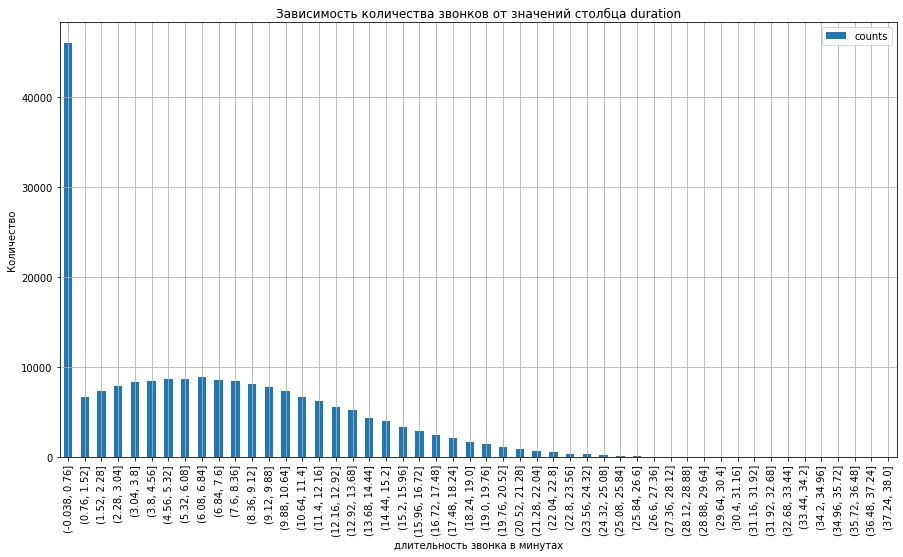

In [43]:
pandas_bar_plot(50, 'duration', 0, 'звонков')

Сильно выдающимся выглядит количество звонков длительностью в долю минуты, хотя в остальном распределение длин звонков выглядит как пуассоновское. Возможно, это все обусловлено звонками нулевой длины (которые являются неотвеченными). Проверим это.

Количество звонков нулевой длины: 39613
Доля звонков нулевой длины: 19.551644316336553 %


Text(0, 0.5, 'Количество')

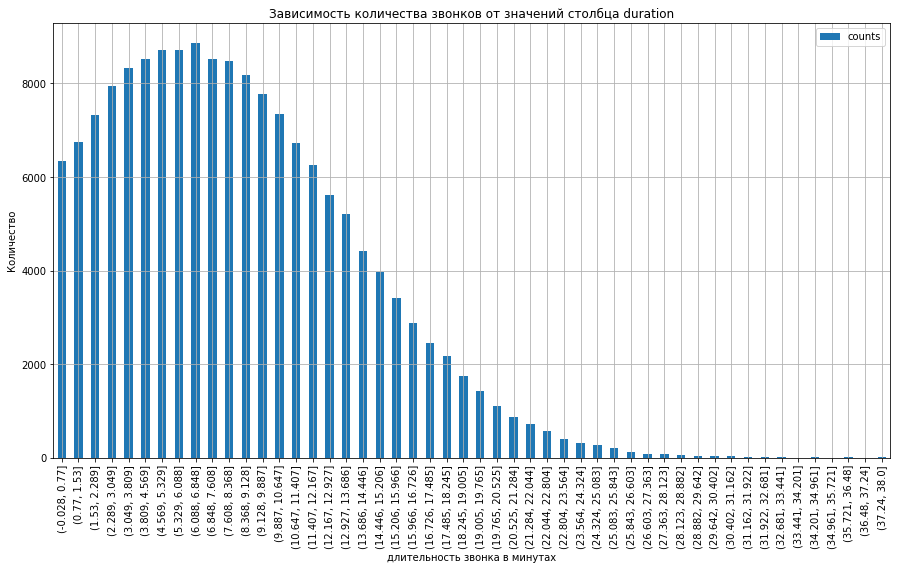

In [44]:
print('Количество звонков нулевой длины:', data[data['duration'] == 0]['duration'].count())
print('Доля звонков нулевой длины:', 100*data[data['duration'] == 0]['duration'].count()/data['duration'].count(), '%')

cur_data = data[data['duration'] != 0]
category_col =  'duration_category'
cur_data[category_col] = pd.cut(cur_data['duration'].to_list(), 50)
plot_data = cur_data[category_col].value_counts().sort_index().rename_axis(category_col).reset_index(name='counts')
title = 'Зависимость количества звонков от значений столбца ' + 'duration'
plt = plot_data.plot(x=category_col, y='counts', kind='bar', title=title, grid=True, figsize=(15,8))
plt.set_xlabel(column_describe[0]['duration'])
plt.set_ylabel('Количество')

#### Столбец _mb_used_

In [45]:
print_base_info('mb_used', 0)

объём потраченного за сессию интернет-трафика (в мегабайтах)
count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64
Уникальных значений: 70003


id       date  duration  user_id session_type  mb_used  \
137493    1461_9 2018-11-28       NaN     1461     INTERNET  1724.83   
119156  1402_191 2018-10-26       NaN     1402     INTERNET  1702.75   
7063    1024_118 2018-11-15       NaN     1024     INTERNET  1651.55   
103480  1348_138 2018-10-31       NaN     1348     INTERNET  1651.25   
140299  1471_182 2018-07-29       NaN     1471     INTERNET  1623.92   
123640  1415_248 2018-12-11       NaN     1415     INTERNET  1609.06   
53763   1180_254 2018-03-15       NaN     1180     INTERNET  1602.05   
134488   1452_26 2018-08-06       NaN     1452     INTERNET  1579.18   
16360   1056_164 2018-05-26       NaN     1056     INTERNET  1575.26   
102418   1343_25 2018-10-20       NaN     1343     INTERNET  1554.17   

        day_of_week  month duration_category  
137493            2     11               NaN  
119156            4     10               NaN  
7063              3     11               NaN  
103480            2     10               NaN  
140299            6      7               NaN  
123640            1     12               NaN  
53763             3      3               NaN  
134488            0      8               NaN  
16360             5      5               NaN  
102418            5     10               NaN

id       date  duration  user_id session_type  mb_used  \
116616  1393_102 2018-06-03       NaN     1393     INTERNET      0.0   
53410   1179_272 2018-08-11       NaN     1179     INTERNET      0.0   
104303  1353_239 2018-10-26       NaN     1353     INTERNET      0.0   
19438   1065_583 2018-03-26       NaN     1065     INTERNET      0.0   
19437   1065_582 2018-07-14       NaN     1065     INTERNET      0.0   
19436   1065_581 2018-03-08       NaN     1065     INTERNET      0.0   
133730   1448_87 2018-09-22       NaN     1448     INTERNET      0.0   
53416   1179_278 2018-06-22       NaN     1179     INTERNET      0.0   
133732   1448_89 2018-09-16       NaN     1448     INTERNET      0.0   
133734   1448_91 2018-11-03       NaN     1448     INTERNET      0.0   

        day_of_week  month duration_category  
116616            6      6               NaN  
53410             5      8               NaN  
104303            4     10               NaN  
19438             0      3               NaN  
19437             5      7               NaN  
19436             3      3               NaN  
133730            5      9               NaN  
53416             4      6               NaN  
133732            6      9               NaN  
133734            5     11               NaN

Количество дубликатов (уникальные значения): 405035
Количество дубликатов (все значения): 441123
Текущее число пропусков: 325643
68.55079267175958%


Количество пропусков, как мы помним, в нашем случае обусловлено типом действия - для звонков и смс-сообщений оно является корректным.

In [46]:
print('Количество пропусков в столбце duration при условии, что значение столбца sesion_type - INTERNET: ', data[data['mb_used'] == 'INTERNET']['duration'].isna().sum())
print('Количество значимых величин в столбце duration при условии, что значение столбца sesion_type - не INTERNET: ', data[data['session_type'] != 'INTERNET']['session_type'].count() - data[data['session_type'] != 'INTERNET']['mb_used'].isna().sum())

Количество пропусков в столбце duration при условии, что значение столбца sesion_type - INTERNET:  0
Количество значимых величин в столбце duration при условии, что значение столбца sesion_type - не INTERNET:  0


Таким образом, для некоторой строки пропуск в столбце duration есть тогда и только тогда, когда в этой же строке значение столбца session_type - не INTERNET.

Дисперсия: 77451.41939493736


mb_used
count  149396.000000
mean      370.192426
std       278.300951
min         0.000000
25%       138.187500
50%       348.015000
75%       559.552500
max      1724.830000

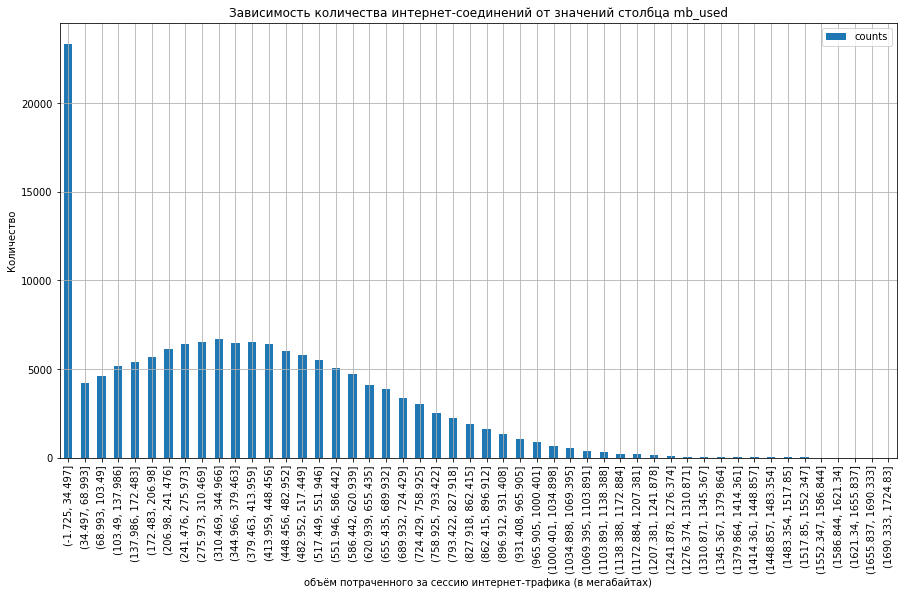

In [47]:
pandas_bar_plot(50, 'mb_used', 0, 'интернет-соединений')

Как мы видели из первой строки - минимальное значение трафика при интренет-соединении равно нулю. Посмотрим на количество строк с таким значением, их долю и на график распределения количества интернет-соединений по потраченному во время них трафику.

Количество интернет-сессий с нулевым количеством трафика: 19598
Доля интернет-сессий с нулевым количеством трафика: 13.118155773916303 %


Text(0, 0.5, 'Количество')

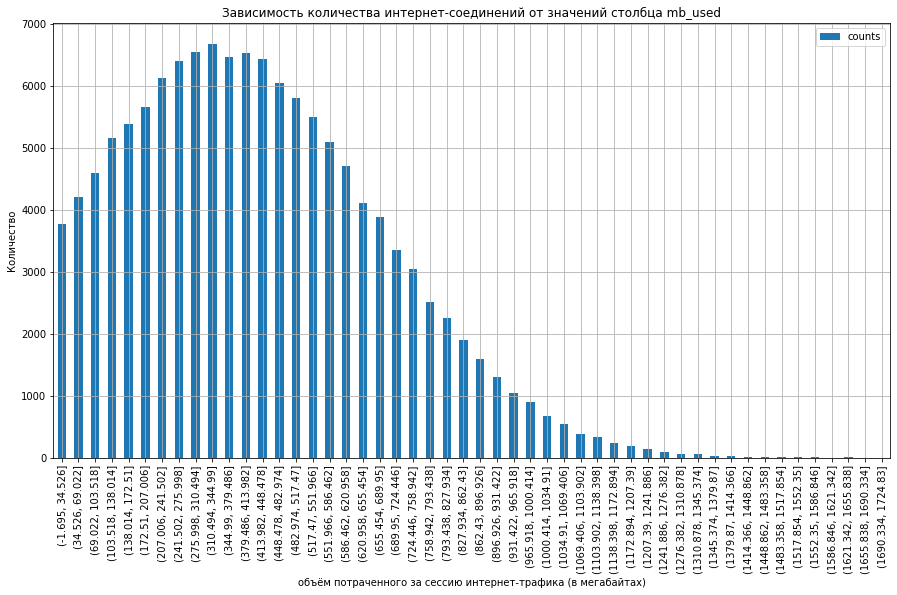

In [48]:
print('Количество интернет-сессий с нулевым количеством трафика:', data[data['mb_used'] == 0]['mb_used'].count())
print('Доля интернет-сессий с нулевым количеством трафика:', 100*data[data['mb_used'] == 0]['mb_used'].count()/data['mb_used'].count(), '%')

cur_data = data[data['mb_used'] != 0]
category_col =  'mb_used_category'
cur_data[category_col] = pd.cut(cur_data['mb_used'].to_list(), 50)
plot_data = cur_data[category_col].value_counts().sort_index().rename_axis(category_col).reset_index(name='counts')
title = 'Зависимость количества интернет-соединений от значений столбца ' + 'mb_used'
plt = plot_data.plot(x=category_col, y='counts', kind='bar', title=title, grid=True, figsize=(15,8))
plt.set_xlabel(column_describe[0]['mb_used'])
plt.set_ylabel('Количество')

Про интернет-соединения с нулевым потраченным трафиком ничего не сказано, однако у них может быть ровно та же природа, что и у звонков с нулевой продолжительностью - возможно, пользователь попытался получить доступ к странице, когда интернет был недоступен. Возможно, это были доступы к несуществующим страницам. Одним словом - это могут быть те ситуации, когда пользователь пытался что-то открыть в сети и запрос на получение данных был отправлен, однако в качестве ответа не было получено ничего.
Возможно, наше предположение неверно и все такие нулевые значения - это пропуски в данных. Но нам не у кого это уточнить, а наша гипотеза звучит правдоподобно, и что самое главное - для нее ничего не нужно делать! Поэтому будем придерживаться ее.

### Вывод

Данные, предоставленные нам, чистые и аккуратные. Нигде нет пропусков, не имеющих под собой логического объяснения. Распределения всех величин имеют пуассоновское распределение там, где это должно быть. Ошибок и коллизий найдено не было.

## Исследовательский анализ данных

Первое, что нам нужно сделать - объединить информацию о всех транзакциях всех типов: посчитать суммарное количество сообщений, суммарное количество трафика, суммарное количество потраченых минут разговора (с учетом округления). Затем нужно будет посчитать суммарные траты согласно используемому клиентом тарифу и исходя из этого вычислить среднее, дисперсию и стандартное отклонение необходимого объема услуг для пользователей каждого из тарифов. После этого нужно будет посчитать траты пользователей и проверить несколько гипотез касательно тарифов, города обитания клиентов и т.д., на основании чего сделать главный вывод работы - какой тариф наиболее перспективный.

### Добавление дополнительных данных

Мы будем считать суммы (звонков, сообщений и т.д.) по каждому клиенту в таблице data, а затем добавлять эти данные в таблицу data_users.

Для начала посчитаем помесячные значения. Будем считать, что ежемесячная плата за тариф списывается каждые 30 дней, и для каждого пользователя будет список с количеством действий каждого вида, которые он совершал в месяцы пользования услугами одного из тарифов Мегалайна. При таком хранении данных у нас не будет понимания, к какому месяцу относится та или иная цифра списка - но нам это и не важно, так как время начала пользования тарифами у большинства пользователей расходится, и, как следствие, у каждого пользователя будут свои месячные отрезки пользования своим тарифом, которые очень сложно сопоставить между собой.

In [49]:
## Для удобного добавления новых данных в таблицу
data_users = data_users.set_index('user_id') 

In [50]:
data = data.set_index('user_id')
data['reg_date'] = data_users['reg_date']
data = data.reset_index()

## Столбец, который показывает для действия, в какой по счету месяц использования клиентом тарифа оно было совершено
data['date_segment'] = np.ceil((data['date'] - data['reg_date'] + pd.Timedelta(days=1))/np.timedelta64(1, 'M'))

In [51]:

column_describe[0]['date_segment'] = 'Номер месяца пользования тарифа клиентом'

data_users['max_segment'] = data.groupby('user_id')['date_segment'].max()

# Для двух загадочных личностей действий в таблице нет
data_users['max_segment'] = data_users['max_segment'].fillna((data_users['churn_date'].fillna(pd.to_datetime('2018-12-31')) - data_users['reg_date']).dt.days)
column_describe[1]['max_segment'] = 'Количество месяцев использования тарифа клиентом в 2018м году'

In [52]:
# 1) делаем сводную таблицу по user_id и порядковому номеру месяца клиента, в полученной таблице сбрасываем мультииндекс
# 2) из полученной таблицы в 13 столбцов делаем один - мерджим в список все 13 значений, включая NaN (заполняя значения нулями)
# 3) заполняем пропуски нулями (в таблице может не быть данных о каком-либо типе действий для конкретного клиента), обрезаем каждый список до величины, равной количеству месяцев пользования тарифом
# 4) profit! мы получим список длиной в количество месяцев использования тарифа

data_users['messages_by_month'] = pd.pivot_table(data[data['session_type'] == 'MESSAGE'], 
               columns='date_segment', 
               values='session_type', 
               index='user_id', 
               aggfunc='count').rename_axis(None).apply(lambda x: 
                                                        ','.join(x.fillna(0).
                                                            astype(str)), axis=1)

data_users['messages_by_month'] = data_users.fillna('0,'*11+'0').apply(lambda row: 
                                                       list(map(float, str(row['messages_by_month']).split(',')))[:int(row['max_segment'])] 
                                                                                                if row['max_segment'] > 0 
                                                                                                else [], 
                                                   axis=1)
column_describe[1]['messages_by_month'] = 'Количество отправленных сообщений по месяцам'

In [53]:
## Для каждого звонка округлим его до ближайшего верхнего целого
data['duration_ceil'] = np.ceil(data['duration'])
column_describe[0]['duration_ceil'] = 'Длительность звонка, округленная до ближайшего большего целого'

# 1) делаем сводную таблицу по user_id и порядковому номеру месяца клиента, в полученной таблице сбрасываем мультииндекс
# 2) из полученной таблицы в 13 столбцов делаем один - мерджим в список все 13 значений, включая NaN (заполняя значения нулями)
# 3) заполняем пропуски нулями (в таблице может не быть данных о каком-либо типе действий для конкретного клиента), обрезаем каждый список до величины, равной количеству месяцев пользования тарифом
# 4) profit! мы получим список длиной в количество месяцев использования тарифа

data_users['duration_by_month'] = pd.pivot_table(data[data['session_type'] == 'CALL'], 
                                                 columns='date_segment', 
                                                 values='duration_ceil', 
                                                 index='user_id', 
                                                 aggfunc='sum').rename_axis(None).apply(lambda x: 
                                                                                        ','.join(x.fillna(0).
                                                                                                 astype(str)), axis=1)

data_users['duration_by_month'] = data_users.fillna('0,'*11+'0').apply(lambda row: 
                                                       list(map(float, str(row['duration_by_month']).split(',')))[:int(row['max_segment'])] 
                                                                                                if row['max_segment'] > 0 
                                                                                                else [], 
                                                   axis=1)
column_describe[1]['duration_by_month'] = 'Общая длительность звонков (с округлением) по месяцам'

In [54]:
## Для каждого звонка округлим его до ближайшего верхнего целого
data['duration_ceil'] = np.ceil(data['duration'])

column_describe[0]['duration_ceil'] = 'Длительность звонка, округленная до ближайшего большего целого'

# 1) делаем сводную таблицу по user_id и порядковому номеру месяца клиента, в полученной таблице сбрасываем мультииндекс
# 2) из полученной таблицы в 13 столбцов делаем один - мерджим в список все 13 значений, включая NaN (заполняя значения нулями)
# 3) заполняем пропуски нулями (в таблице может не быть данных о каком-либо типе действий для конкретного клиента), обрезаем каждый список до величины, равной количеству месяцев пользования тарифом
# 4) profit! мы получим список длиной в количество месяцев использования тарифа

data_users['calls_by_month'] = pd.pivot_table(data[data['session_type'] == 'CALL'], 
                                                 columns='date_segment', 
                                                 values='duration_ceil', 
                                                 index='user_id', 
                                                 aggfunc='count').rename_axis(None).apply(lambda x: 
                                                                                        ','.join(x.fillna(0).
                                                                                                 astype(str)), axis=1)

data_users['calls_by_month'] = data_users.fillna('0,'*11+'0').apply(lambda row: 
                                                       list(map(float, str(row['calls_by_month']).split(',')))[:int(row['max_segment'])] 
                                                                                                if row['max_segment'] > 0 
                                                                                                else [], 
                                                   axis=1)
column_describe[1]['calls_by_month'] = 'Общее количество звонков (с округлением) по месяцам'

In [55]:
# 1) делаем сводную таблицу по user_id и порядковому номеру месяца клиента, в полученной таблице сбрасываем мультииндекс
# 2) из полученной таблицы в 13 столбцов делаем один - мерджим в список все 13 значений, включая NaN (заполняя значения нулями)
# 3) заполняем пропуски нулями (в таблице может не быть данных о каком-либо типе действий для конкретного клиента), обрезаем каждый список до величины, равной количеству месяцев пользования тарифом
# 4) profit! мы получим список длиной в количество месяцев использования тарифа

data_users['internet_by_month'] = pd.pivot_table(data[data['session_type'] == 'INTERNET'], 
               columns='date_segment', 
               values='mb_used', 
               index='user_id', 
               aggfunc='sum').rename_axis(None).apply(lambda x: 
                                                          ','.join(x.fillna(0).
                                                              astype(str)), axis=1)
## Не забываем округлить мегабайты до ближайшего большего целого в каждый месяц!
def mb_apply(row):
    if row['max_segment'] == 0:
        return []
    res_list = list(map(float, str(row['internet_by_month']).split(',')))[:int(row['max_segment'])]
    return np.ceil([float (x)/1024 for x in res_list])

data_users['internet_by_month'] = data_users.fillna('0,'*11+'0').apply(lambda row: mb_apply(row), 
                                                   axis=1)
column_describe[1]['internet_by_month'] = 'Общее количество использованных гигабайт трафика по месяцам'

In [56]:
data_users.head(10)

age churn_date              city first_name  last_name   reg_date  \
user_id                                                                      
1000      52        NaT         КРАСНОДАР     Рафаил  Верещагин 2018-05-25   
1001      41        NaT            МОСКВА       Иван       Ежов 2018-11-01   
1002      59        NaT       СТЕРЛИТАМАК    Евгений  Абрамович 2018-06-17   
1003      23        NaT            МОСКВА      Белла   Белякова 2018-08-17   
1004      68        NaT       НОВОКУЗНЕЦК    Татьяна   Авдеенко 2018-05-14   
1005      67        NaT  НАБЕРЕЖНЫЕ ЧЕЛНЫ   Афанасий     Горлов 2018-01-25   
1006      21        NaT         УЛЬЯНОВСК     Леонид   Ермолаев 2018-02-26   
1007      65        NaT            МОСКВА        Юна   Березина 2018-04-19   
1008      63        NaT         ЧЕЛЯБИНСК     Рустэм  Пономарёв 2018-12-19   
1009      24        NaT             ПЕРМЬ   Василиса    Блинова 2018-03-22   

        tariff  reg_day_of_week  reg_month  churn_day_of_week  churn_month  \
user_id                                                                      
1000     ultra                4          5                NaN          NaN   
1001     smart                3         11                NaN          NaN   
1002     smart                6          6                NaN          NaN   
1003     ultra                4          8                NaN          NaN   
1004     ultra                0          5                NaN          NaN   
1005     smart                3          1                NaN          NaN   
1006     smart                0          2                NaN          NaN   
1007     smart                3          4                NaN          NaN   
1008     smart                2         12                NaN          NaN   
1009     smart                3          3                NaN          NaN   

         max_segment                                  messages_by_month  \
user_id                                                                   
1000             8.0   [60.0, 71.0, 80.0, 72.0, 57.0, 70.0, 72.0, 14.0]   
1001             3.0                                    [0.0, 0.0, 0.0]   
1002             7.0             [8.0, 14.0, 8.0, 5.0, 14.0, 16.0, 5.0]   
1003             5.0                     [78.0, 97.0, 80.0, 87.0, 38.0]   
1004             8.0  [148.0, 157.0, 160.0, 160.0, 146.0, 161.0, 170...   
1005            12.0  [39.0, 52.0, 46.0, 42.0, 42.0, 56.0, 54.0, 59....   
1006            11.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1007             9.0  [32.0, 33.0, 26.0, 24.0, 30.0, 21.0, 25.0, 24....   
1008             1.0                                             [56.0]   
1009            10.0  [12.0, 8.0, 8.0, 20.0, 11.0, 8.0, 16.0, 10.0, ...   

                                         duration_by_month  \
user_id                                                      
1000     [299.0, 280.0, 403.0, 465.0, 370.0, 323.0, 363...   
1001                                   [430.0, 414.0, 0.0]   
1002      [220.0, 262.0, 213.0, 205.0, 204.0, 315.0, 98.0]   
1003                   [919.0, 853.0, 806.0, 905.0, 339.0]   
1004     [92.0, 152.0, 143.0, 147.0, 87.0, 166.0, 87.0,...   
1005     [504.0, 528.0, 745.0, 565.0, 601.0, 599.0, 601...   
1006     [272.0, 391.0, 361.0, 470.0, 296.0, 289.0, 398...   
1007     [521.0, 464.0, 568.0, 513.0, 548.0, 582.0, 493...   
1008                                               [339.0]   
1009     [268.0, 316.0, 211.0, 193.0, 268.0, 150.0, 202...   

                                            calls_by_month  \
user_id                                                      
1000       [53.0, 46.0, 54.0, 53.0, 56.0, 48.0, 51.0, 7.0]   
1001                                     [59.0, 62.0, 1.0]   
1002            [28.0, 34.0, 37.0, 33.0, 35.0, 35.0, 15.0]   
1003                    [130.0, 111.0, 106.0, 120.0, 53.0]   
1004      [21.0, 26.0, 21.0, 25.0, 21.0, 32.0, 15.0, 15.0]   
1005     [77.0, 70.0, 103.0, 72.0, 77.0, 79.0, 71.0, 65

Прекрасно, все ежемесячные величины получены. Теперь посчитаем ежемесячные расходы клиентов на связь - они будут равны абоненской плате плюс стоимость излишков по каждому типу услуг. Результаты также запишем в виде отдельного столбца со значением в виде массива.

In [57]:
data_tariffs = data_tariffs.set_index('tariff_name')

In [58]:
def calculate(row):
    tariff = row['tariff']    
    if pd.isna(len(row['internet_by_month']) != row['max_segment']):
        print(row)
    if pd.isna(len(row['messages_by_month']) != row['max_segment']):
        print(row)
    if pd.isna(len(row['duration_by_month']) != row['max_segment']):
        print(row)
        
    return (pd.Series([data_tariffs.loc[tariff, 'rub_monthly_fee']]*int(row['max_segment'])) # абонентская плата
            + pd.Series([data_tariffs.loc[tariff, 'rub_per_gb']*max(a, 0) for a in (pd.Series(row['internet_by_month']) - pd.Series([data_tariffs.loc[tariff, 'mb_per_month_included']/1024]*int(row['max_segment']))).tolist()]) # доп.траты на интернет
            + pd.Series([data_tariffs.loc[tariff, 'rub_per_message']*max(a, 0) for a in (pd.Series(row['messages_by_month']) - pd.Series([data_tariffs.loc[tariff, 'messages_included']]*int(row['max_segment']))).tolist()]) # доп.траты на сообщения
            + pd.Series([data_tariffs.loc[tariff, 'rub_per_minute']*max(a, 0) for a in (pd.Series(row['duration_by_month']) - pd.Series([data_tariffs.loc[tariff, 'minutes_included']]*int(row['max_segment']))).tolist()])).tolist() # доп.траты на звонки
    
data_users['total_cost'] = data_users.apply(lambda x: calculate(x), axis=1)

column_describe[1]['total_cost'] = 'Общее траты на связь по месяцам'

Также посчитаем общее число использованных ресурсов каждого типа и среднее ежемесячное использование для каждого клиента. 

In [59]:
# для звонков округляем каждый отдельный звонок 
data_users['duration_sum'] = data.groupby('user_id')['duration_ceil'].sum()
column_describe[1]['duration_sum'] = 'Общее длительность всех звонков за год'

# трафик округляется в большую сторону до целого числа гигабайт после суммирования
data_users['mb_used_sum'] = data.groupby('user_id')['mb_used'].sum()
data_users['gb_used_sum'] = data_users['mb_used_sum']//1024 + np.ceil((data_users['mb_used_sum']%1024)/1024)
column_describe[1]['gb_used_sum'] = 'Общее количество интернет-трафика за год'

# для сообщений - просто считаем количество строк, где столбец session_type 
data_users['message_sum'] = data[data['session_type'] == 'MESSAGE'].groupby('user_id')['session_type'].count()
data_users['message_sum'] = data_users['message_sum'].fillna(0)
column_describe[1]['message_sum'] = 'Общее количество отправленных сообщений за год'

data_users.head(20)

age churn_date              city first_name   last_name   reg_date  \
user_id                                                                       
1000      52        NaT         КРАСНОДАР     Рафаил   Верещагин 2018-05-25   
1001      41        NaT            МОСКВА       Иван        Ежов 2018-11-01   
1002      59        NaT       СТЕРЛИТАМАК    Евгений   Абрамович 2018-06-17   
1003      23        NaT            МОСКВА      Белла    Белякова 2018-08-17   
1004      68        NaT       НОВОКУЗНЕЦК    Татьяна    Авдеенко 2018-05-14   
1005      67        NaT  НАБЕРЕЖНЫЕ ЧЕЛНЫ   Афанасий      Горлов 2018-01-25   
1006      21        NaT         УЛЬЯНОВСК     Леонид    Ермолаев 2018-02-26   
1007      65        NaT            МОСКВА        Юна    Березина 2018-04-19   
1008      63        NaT         ЧЕЛЯБИНСК     Рустэм   Пономарёв 2018-12-19   
1009      24        NaT             ПЕРМЬ   Василиса     Блинова 2018-03-22   
1010      26        NaT            ТЮМЕНЬ     Эдуард     Кононов 2018-08-05   
1011      44        NaT            САМАРА   Веселина      Алёшко 2018-03-19   
1012      38        NaT   САНКТ-ПЕТЕРБУРГ     Варлам    Соловьев 2018-03-28   
1013      36        NaT           ИВАНОВО      Борис   Андреенко 2018-11-14   
1014      64        NaT         ЧЕБОКСАРЫ       Яков    Акинфьев 2018-05-15   
1015      26        NaT         ЧЕЛЯБИНСК     Рузана     Алюшина 2018-04-30   
1016      58        NaT              ОМСК     Марица    Сазонова 2018-11-21   
1017      73        NaT         КРАСНОДАР      Мария  Аленникова 2018-05-22   
1018      71        NaT               УФА     Матвей     Золотов 2018-04-01   
1019      63 2018-10-05             ТОМСК    Игнатий     Круглов 2018-05-16   

        tariff  reg_day_of_week  reg_month  churn_day_of_week  churn_month  \
user_id                                                                      
1000     ultra                4          5                NaN          NaN   
1001     smart                3         11                NaN          NaN   
1002     smart                6          6                NaN          NaN   
1003     ultra                4          8                NaN          NaN   
1004     ultra                0          5                NaN          NaN   
1005     smart                3          1                NaN          NaN   
1006     smart                0          2                NaN          NaN   
1007     smart                3          4                NaN          NaN   
1008     smart                2         12                NaN          NaN   
1009     smart                3          3                NaN          NaN   
1010     smart                6          8                NaN          NaN   
1011     smart                0          3                NaN          NaN   
1012     smart                2          3                NaN          NaN   
1013     ultra                2         11                NaN          NaN   
1014     smart                1          5                NaN          NaN   
1015     smart                0          4                NaN          NaN   
1016     ultra                2         11                NaN          NaN   
1017     smart                1          5                NaN          NaN   
1018     ultra                6          4                NaN          NaN   
1019     ultra                2          5                4.0         10.0   

         max_segment                                  messages_by_month  \
user_id                                                                   
1000             8.0   [60.0, 71.0, 80.0, 72.0, 57.0, 70.0, 72.0, 14.0]   
1001             3.0                                    [0.0, 0.0, 0.0]   
1002             7.0             [8.0, 14.0, 8.0, 5.0, 14.0, 16.0, 5.0]   
1003             5.0                     [78.0, 97.0, 80.0, 87.0, 38.0]   
1004             8.0  [148.0, 157.0, 160.0, 160.0, 146.0, 161.0, 170...   
1005            12.0  [39.0,

Теперь чтобы посчитать средние ежемесячные величины, нужно суммарное количество кажого параметра поделить на число месяцев, которое клиент из данного нам периода (2018й год) был подключен к своему тарифу. Проще всего число месяцев посчитать приближенно, посчитав общее число дней - это разница значений столбцов churn_date (или 31.12.2018, если в churn_date NaN) и reg_date - и поделить его на 30.
Стоит отметить, что при подсчете таким образом среднего количества траффика также будет возникать некоторая неточность - гигабайты нужно округлять каждый месяц, а мы округлили их всего один раз, для суммарного числа  

In [60]:
month_mean = (pd.to_datetime(data_users['churn_date'].fillna('2019-1-1')) - pd.to_datetime(data_users['reg_date'])).dt.days/30

data_users['duration_mean'] = data_users['duration_sum']/month_mean
column_describe[1]['duration_mean'] = 'Средняя ежемесячная длительность всех звонков за год'

data_users['gb_used_mean'] = data_users['gb_used_sum']/month_mean
column_describe[1]['gb_used_mean'] = 'Среднее ежемесячное количество интернет-трафика за год'

data_users['message_mean'] = data_users['message_sum']/month_mean
column_describe[1]['message_mean'] = 'Среднее ежемесячное количество отправленных сообщений за год'

data_users.head(20)

age churn_date              city first_name   last_name   reg_date  \
user_id                                                                       
1000      52        NaT         КРАСНОДАР     Рафаил   Верещагин 2018-05-25   
1001      41        NaT            МОСКВА       Иван        Ежов 2018-11-01   
1002      59        NaT       СТЕРЛИТАМАК    Евгений   Абрамович 2018-06-17   
1003      23        NaT            МОСКВА      Белла    Белякова 2018-08-17   
1004      68        NaT       НОВОКУЗНЕЦК    Татьяна    Авдеенко 2018-05-14   
1005      67        NaT  НАБЕРЕЖНЫЕ ЧЕЛНЫ   Афанасий      Горлов 2018-01-25   
1006      21        NaT         УЛЬЯНОВСК     Леонид    Ермолаев 2018-02-26   
1007      65        NaT            МОСКВА        Юна    Березина 2018-04-19   
1008      63        NaT         ЧЕЛЯБИНСК     Рустэм   Пономарёв 2018-12-19   
1009      24        NaT             ПЕРМЬ   Василиса     Блинова 2018-03-22   
1010      26        NaT            ТЮМЕНЬ     Эдуард     Кононов 2018-08-05   
1011      44        NaT            САМАРА   Веселина      Алёшко 2018-03-19   
1012      38        NaT   САНКТ-ПЕТЕРБУРГ     Варлам    Соловьев 2018-03-28   
1013      36        NaT           ИВАНОВО      Борис   Андреенко 2018-11-14   
1014      64        NaT         ЧЕБОКСАРЫ       Яков    Акинфьев 2018-05-15   
1015      26        NaT         ЧЕЛЯБИНСК     Рузана     Алюшина 2018-04-30   
1016      58        NaT              ОМСК     Марица    Сазонова 2018-11-21   
1017      73        NaT         КРАСНОДАР      Мария  Аленникова 2018-05-22   
1018      71        NaT               УФА     Матвей     Золотов 2018-04-01   
1019      63 2018-10-05             ТОМСК    Игнатий     Круглов 2018-05-16   

        tariff  reg_day_of_week  reg_month  churn_day_of_week  churn_month  \
user_id                                                                      
1000     ultra                4          5                NaN          NaN   
1001     smart                3         11                NaN          NaN   
1002     smart                6          6                NaN          NaN   
1003     ultra                4          8                NaN          NaN   
1004     ultra                0          5                NaN          NaN   
1005     smart                3          1                NaN          NaN   
1006     smart                0          2                NaN          NaN   
1007     smart                3          4                NaN          NaN   
1008     smart                2         12                NaN          NaN   
1009     smart                3          3                NaN          NaN   
1010     smart                6          8                NaN          NaN   
1011     smart                0          3                NaN          NaN   
1012     smart                2          3                NaN          NaN   
1013     ultra                2         11                NaN          NaN   
1014     smart                1          5                NaN          NaN   
1015     smart                0          4                NaN          NaN   
1016     ultra                2         11                NaN          NaN   
1017     smart                1          5                NaN          NaN   
1018     ultra                6          4                NaN          NaN   
1019     ultra                2          5                4.0         10.0   

         max_segment                                  messages_by_month  \
user_id                                                                   
1000             8.0   [60.0, 71.0, 80.0, 72.0, 57.0, 70.0, 72.0, 14.0]   
1001             3.0                                    [0.0, 0.0, 0.0]   
1002             7.0             [8.0, 14.0, 8.0, 5.0, 14.0, 16.0, 5.0]   
1003             5.0                     [78.0, 97.0, 80.0, 87.0, 38.0]   
1004             8.0  [148.0, 157.0, 160.0, 160.0, 146.0, 161.0, 170...   
1005            12.0  [39.0,

### Визуализация и промежуточные выводы

Визуализируем все то, что мы наплодили в предыдущем пункте

In [61]:
# Функция визуализации данных, когда в ячейках находятся списки

def series_with_list_plot(data_ind, plot_data, col, bins, text):
    cur_data = plot_data[col].explode().astype(int).reset_index(drop=True).to_frame()
    print('Дисперсия:', cur_data.var()[col])
    display(cur_data.describe())
    category_col = col + '_category'
    cur_data[category_col] = pd.cut(cur_data[col].to_list(), bins)
    plot_data = cur_data[category_col].value_counts().sort_index().rename_axis(category_col).reset_index(name='counts')
    title = 'Зависимость количества ' + text + ' от значений столбца ' + col
    plt = plot_data.plot(x=category_col, y='counts', kind='bar', title=title, grid=True, figsize=(15,8))
    plt.set_xlabel(column_describe[data_ind][col])
    plt.set_ylabel('Количество')

Дисперсия: 608193.6908497395


total_cost
count  3230.000000
mean   1512.113003
std     779.867739
min     550.000000
25%     750.000000
50%    1593.500000
75%    1950.000000
max    6510.000000

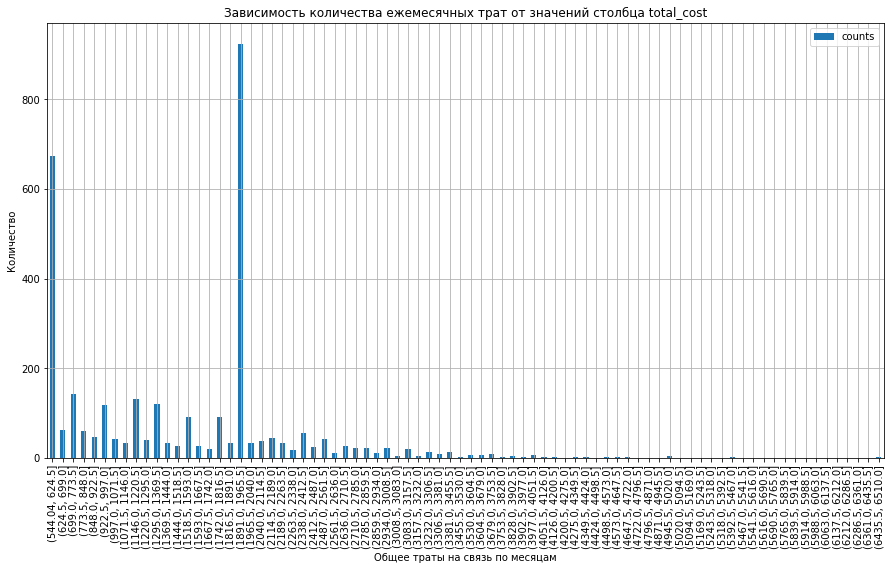

In [62]:
series_with_list_plot(1, data_users, 'total_cost', 80, 'ежемесячных трат')

График не имеет какого-либо узнаваемого распределения в своих очертаниях, но видны два пика, примерно совпадающие со стоимостью тарифов. Что интересно, число клиентов, ежемесячно тратящих сумму, примерно равную стоимости тарифа Ультра (заметим, это не обязательно пользователи тарифа Ультра - это могут быть и пользователи тарифа Смарт, сильно выходящие за рамки входящих в тариф услуг), больше, чем число клиентов, которые платят стоимость тарифа Смарт и никак не выходят за пределы предоставленных им услуг, входящих в абоненскую плату.

In [63]:
print('Количество пользователей тарифа Смарт', data_users[data_users['tariff'] == 'smart']['tariff'].count())
print('Количество пользователей тарифа Ультра', data_users[data_users['tariff'] == 'ultra']['tariff'].count())

Количество пользователей тарифа Смарт 351
Количество пользователей тарифа Ультра 149


Но количество пользователей говорит об обратном! Значит, либо пользователи тарифа Ультра дольше пользуются своим тарифом, либо пользователи тарифа Смарт часто тратят больше, чем входит в их тариф. Посчитаем общее число месяцев, которым пользовались все клиенты своими тарифами.

In [64]:
print('Количество месяцев пользования тарифом Смарт', data_users[data_users['tariff'] == 'smart']['max_segment'].sum())
print('Количество месяцев пользования тарифом Ультра', data_users[data_users['tariff'] == 'ultra']['max_segment'].sum())

Количество месяцев пользования тарифом Смарт 2239.0
Количество месяцев пользования тарифом Ультра 991.0


По месяцам также преимущество у Смарта. 
Построим графики трат отдельно для пользователей разных тарифов.
Для Смарта:

Дисперсия: 618385.0497349519


total_cost
count  2239.000000
mean   1266.514069
std     786.374624
min     550.000000
25%     556.000000
50%    1030.000000
75%    1750.000000
max    6510.000000

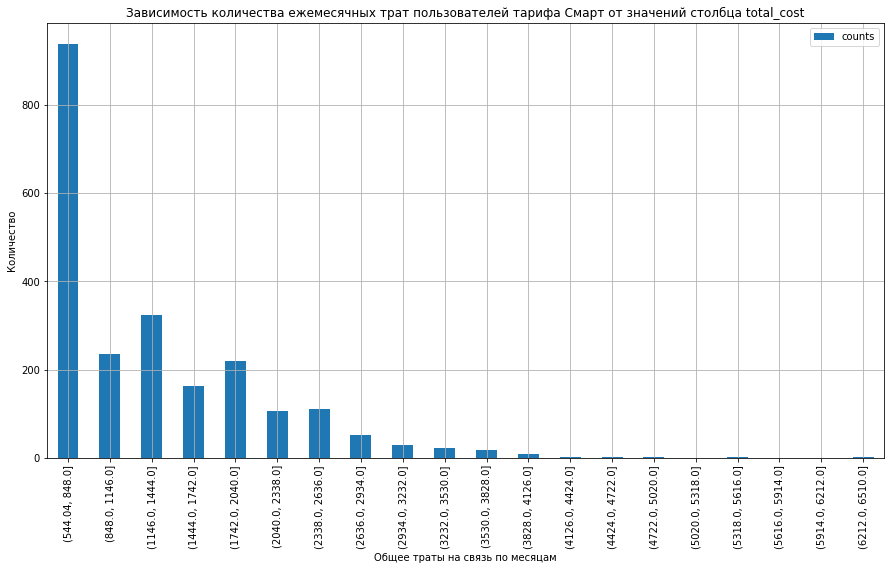

In [65]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'smart'], 'total_cost', 20, 'ежемесячных трат пользователей тарифа Смарт')

Для пользователей тарифом Ультра:

Дисперсия: 141137.37271809994


total_cost
count   991.000000
mean   2067.003027
std     375.682542
min    1950.000000
25%    1950.000000
50%    1950.000000
75%    1950.000000
max    5400.000000

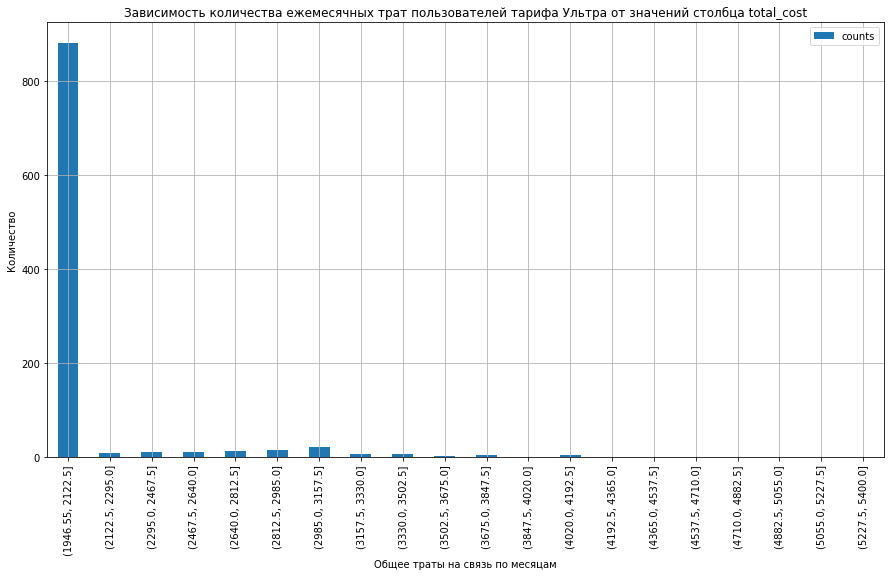

In [66]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'ultra'], 'total_cost', 20, 'ежемесячных трат пользователей тарифа Ультра')

Пользователи тарифа Ультра практически всегда укладываются в услуги, предоставляемые их тарифом. Пользователи же тарифа Смарт, напротив, часто любят превысить лимиты (на глаз - больше чем в половине случаев).


* Средние траты для всех клиентов - 1486 рублей, стандартное отклонение - 772 рубля, медиана - 1550 рублей, дисперсия - 595984
* Средние траты для клиентов тарифа Смарт - 1232 рубля, стандартное отклонение - 767 рублей, медиана - 962 рубля, дисперсия 588289
* Средние траты для клиентов тарифа Ультра - 2067 рублей, стандартное отклонение - 375 рубля, медиана - 1950 рублей, дисперсия - 141137 рублей в квадрате

Теперь посмотрим на распределение каждого вида услуг. Для каждого построим три графика - один для всех клиентов и по одному на пользователей каждого тарифа отдельно.

Дисперсия: 1288.6562013946707


messages_by_month
count        3230.000000
mean           38.091641
std            35.897858
min             0.000000
25%             9.000000
50%            30.000000
75%            57.000000
max           223.000000

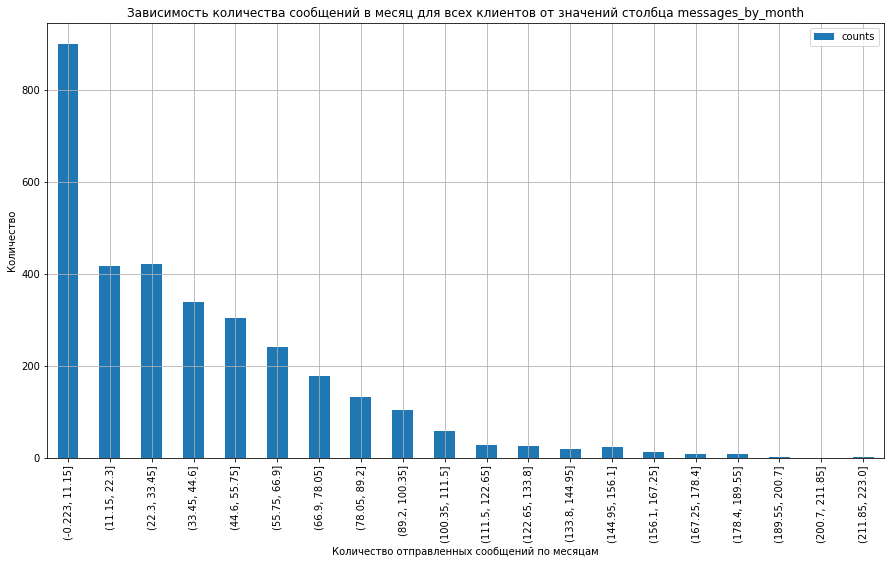

In [67]:
series_with_list_plot(1, data_users, 'messages_by_month', 20, 'сообщений в месяц для всех клиентов')

Средние количество сообщений в месяц для всех клиентов - 38, стандартное отклонение - 35, медиана - 30.

Дисперсия: 782.3201200906351


messages_by_month
count        2239.000000
mean           33.234926
std            27.969986
min             0.000000
25%            10.000000
50%            28.000000
75%            51.000000
max           140.000000

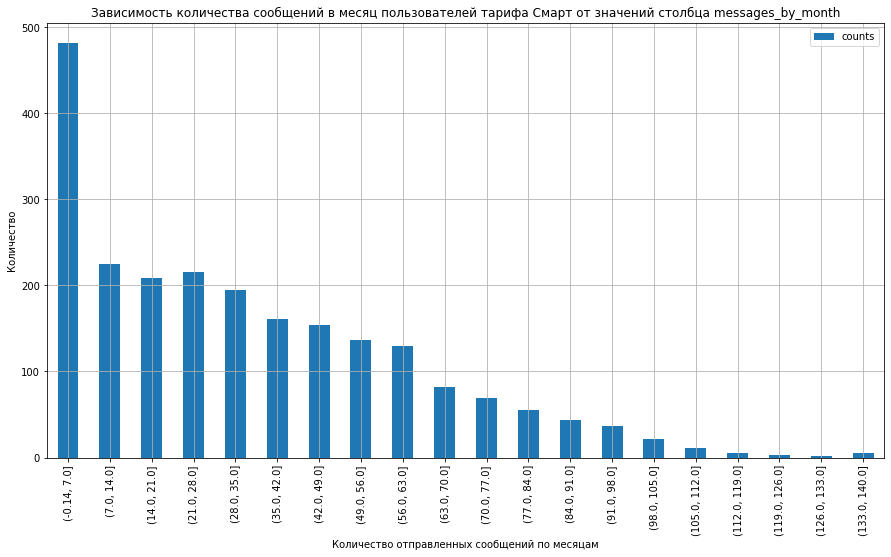

In [68]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'smart'], 'messages_by_month', 20, 'сообщений в месяц пользователей тарифа Смарт')

Средние количество сообщений в месяц для клиентов тарифа Смарт - 32, стандартное отклонение - 27, медиана - 28.

Дисперсия: 2260.710976566884


messages_by_month
count         991.000000
mean           49.064581
std            47.546934
min             0.000000
25%             6.000000
50%            37.000000
75%            78.500000
max           223.000000

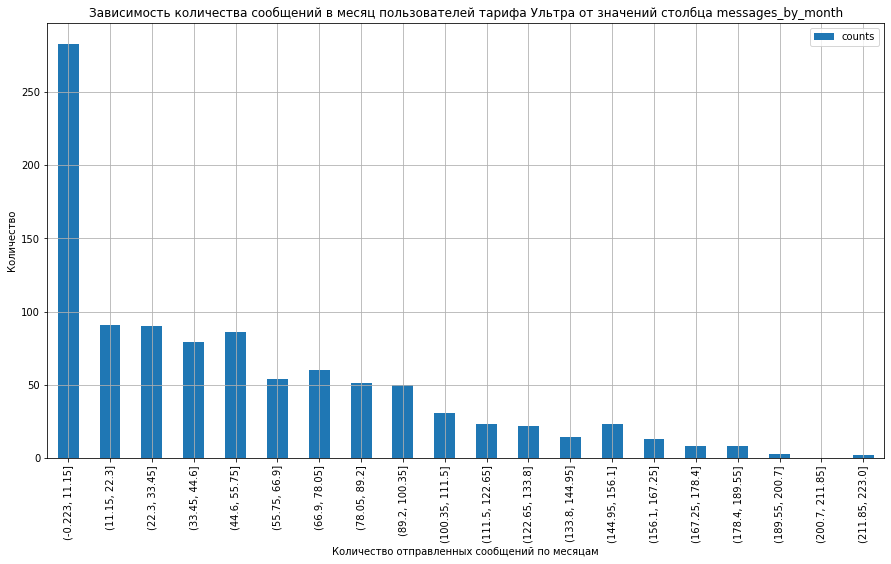

In [69]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'ultra'], 'messages_by_month', 20, 'сообщений в месяц пользователей тарифа Ультра')

Средние количество сообщений в месяц для всех клиентов - 48, стандартное отклонение - 46, медиана - 37.

 В целом можно сказать, что пользователи тарифа Ультра отправляют сообщения в среднем чаще (в полтора раза) и с бОльшим разбросом.

Дисперсия: 1082.1621586301383


calls_by_month
count     3230.000000
mean        62.726625
std         32.896233
min          0.000000
25%         40.000000
50%         62.000000
75%         82.000000
max        233.000000

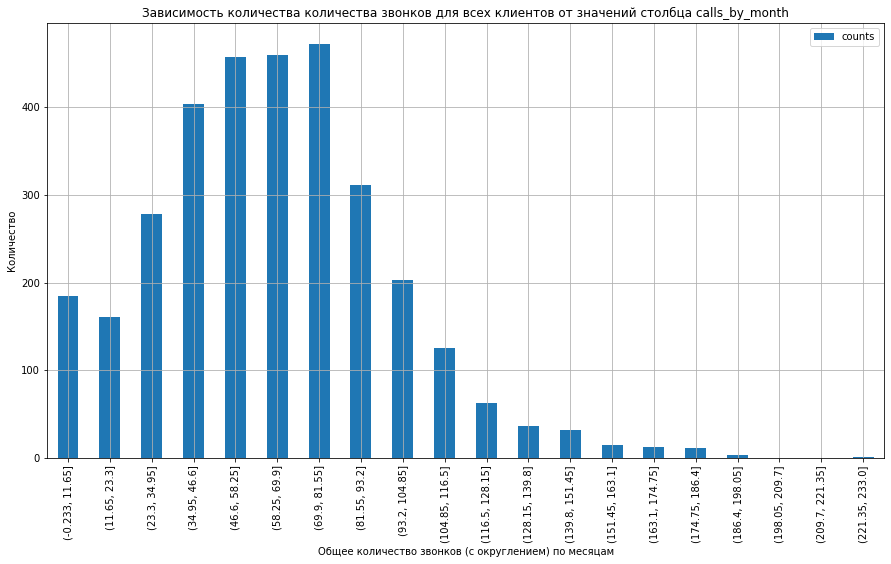

In [70]:
series_with_list_plot(1, data_users, 'calls_by_month', 20, 'количества звонков для всех клиентов')

Средние количество звонков в месяц для всех клиентов - 62, стандартное отклонение - 33, медиана - 61.

Дисперсия: 657.6082877226007


calls_by_month
count     2239.000000
mean        58.202322
std         25.643874
min          0.000000
25%         40.000000
50%         59.000000
75%         75.000000
max        183.000000

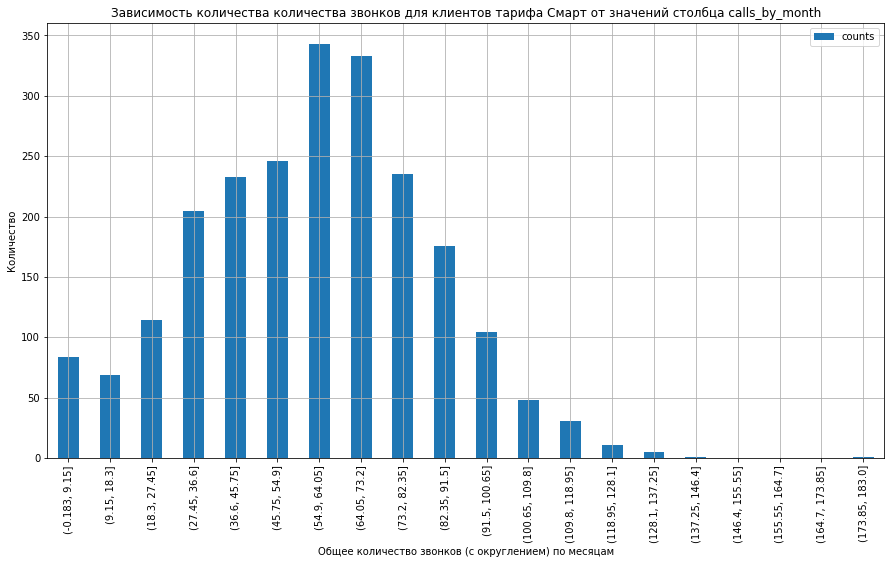

In [71]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'smart'], 'calls_by_month', 20, 'количества звонков для клиентов тарифа Смарт')

Средние количество звонков в месяц для клиентов тарифа Смарт - 57, стандартное отклонение - 25, медиана - 59.

Дисперсия: 1892.1175508872764


calls_by_month
count      991.000000
mean        72.948537
std         43.498478
min          0.000000
25%         40.000000
50%         72.000000
75%        102.000000
max        233.000000

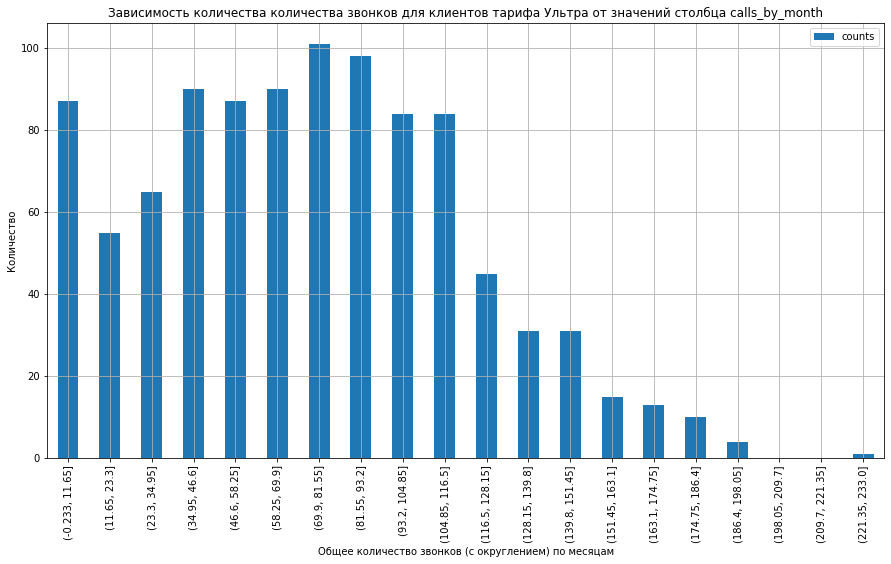

In [72]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'ultra'], 'calls_by_month', 20, 'количества звонков для клиентов тарифа Ультра')

Средние количество звонков в месяц для клиентов тарифа Ультра - 72, стандартное отклонение - 43, медиана - 72.

В целом - распределения по количеству звонков в месяц во всех трех случаях отдаленно напоминают пуассоновское. В распределении пользователей тарифа Ультра толще хвосты и максимум (весьма ожидаемо) правее.

Дисперсия: 57351.23217791162


duration_by_month
count        3230.000000
mean          449.009598
std           239.481173
min             0.000000
25%           286.000000
50%           439.000000
75%           582.000000
max          1593.000000

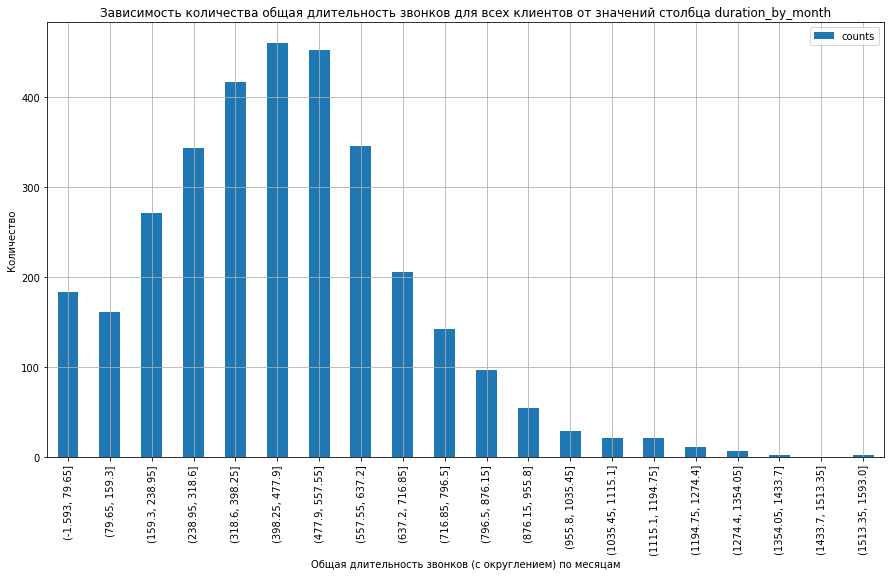

In [73]:
series_with_list_plot(1, data_users, 'duration_by_month', 20, 'общая длительность звонков для всех клиентов')

Средняя длина звонков в месяц для всех клиентов - 442, стандартное отклонение - 237, медиана - 432, дисперсия - 57351.

Дисперсия: 35260.20489047637


duration_by_month
count        2239.000000
mean          416.068334
std           187.777008
min             0.000000
25%           286.000000
50%           419.000000
75%           544.500000
max          1378.000000

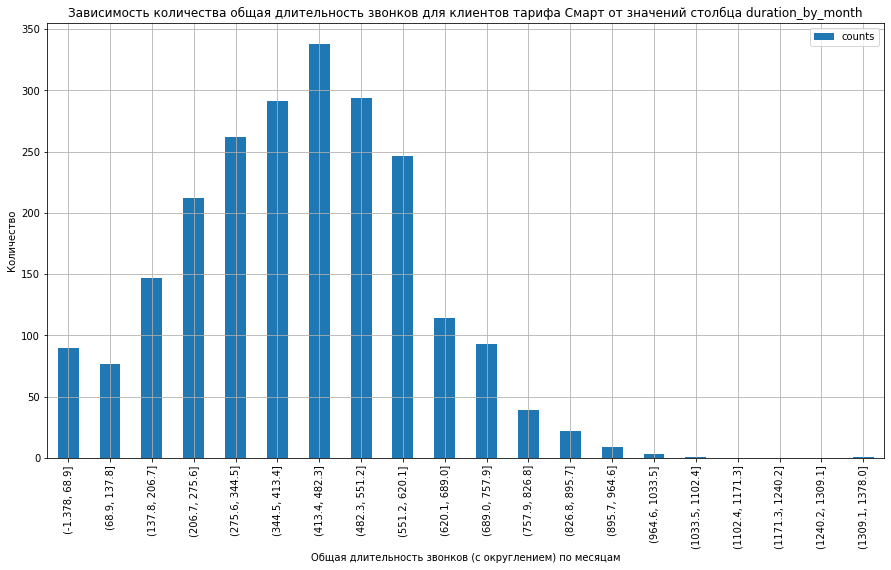

In [74]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'smart'], 'duration_by_month', 20, 'общая длительность звонков для клиентов тарифа Смарт')

Средняя длина звонков в месяц для клиентов тарифа Смарт - 410, стандартное отклонение - 186, медиана - 415, дисперсия - 35260

Дисперсия: 99349.40964845222


duration_by_month
count         991.000000
mean          523.434914
std           315.197414
min             0.000000
25%           286.500000
50%           510.000000
75%           739.000000
max          1593.000000

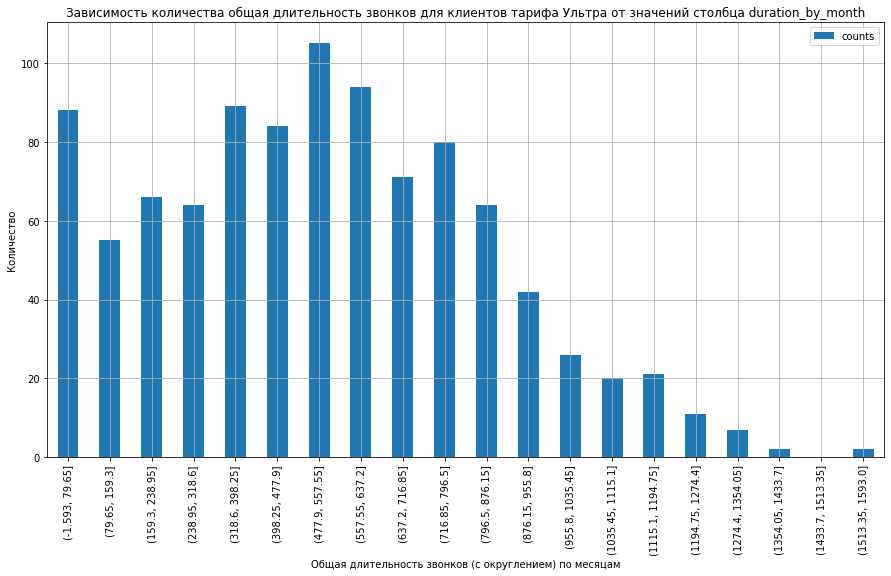

In [75]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'ultra'], 'duration_by_month', 20, 'общая длительность звонков для клиентов тарифа Ультра')

Средняя длина звонков в месяц для клиентов тарифа Ультра - 517, стандартное отклонение - 311, медиана - 507, дисперсия - 99349

В целом - распределения по количеству звонков в месяц во всех трех случаях отдаленно напоминают пуассоновское. В распределении пользователей тарифа Ультра толще хвосты и максимум (весьма ожидаемо) правее.

Дисперсия: 53.9693939501444


internet_by_month
count        3230.000000
mean           17.213932
std             7.346386
min             0.000000
25%            13.000000
50%            17.000000
75%            21.000000
max            53.000000

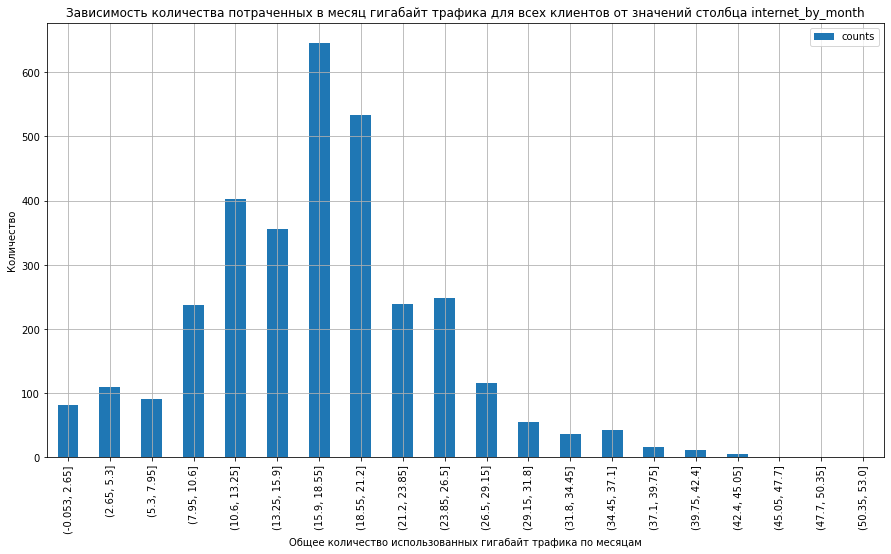

In [76]:
series_with_list_plot(1, data_users, 'internet_by_month', 20, 'потраченных в месяц гигабайт трафика для всех клиентов')

Среднее количество потраченных в месяц гигабайт трафика в месяц для всех клиентов - 16, стандартное отклонение - 7, медиана - 17, дисперсия - 54

Дисперсия: 31.89874038143384


internet_by_month
count        2239.000000
mean           16.255025
std             5.647897
min             0.000000
25%            13.000000
50%            16.000000
75%            20.000000
max            37.000000

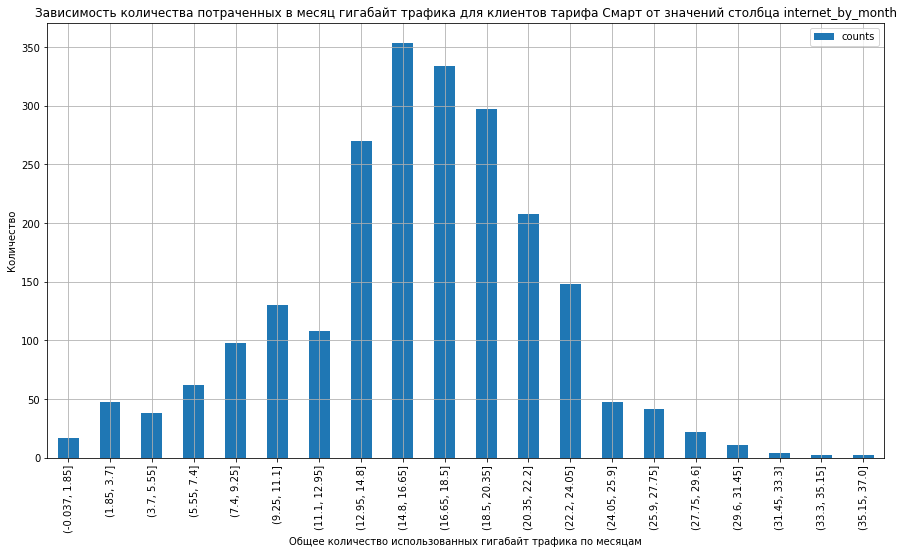

In [77]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'smart'], 'internet_by_month', 20, 'потраченных в месяц гигабайт трафика для клиентов тарифа Смарт')

Среднее количество потраченных в месяц гигабайт трафика в месяц для клиентов тарифа Смарт - 16, стандартное отклонение - 5, медиана - 16, дисперсия - 32

Дисперсия: 97.13896992121026


internet_by_month
count         991.000000
mean           19.380424
std             9.855910
min             0.000000
25%            12.000000
50%            19.000000
75%            26.000000
max            53.000000

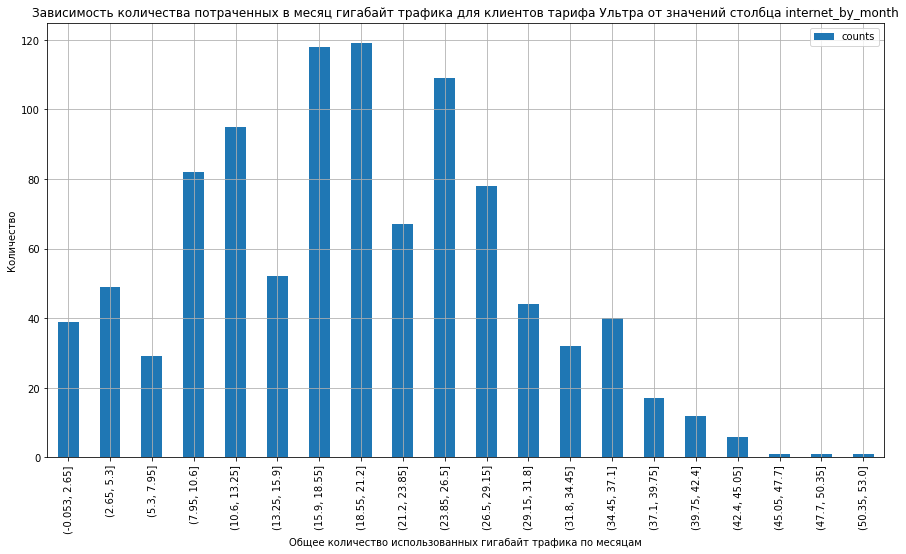

In [78]:
series_with_list_plot(1, data_users[data_users['tariff'] == 'ultra'], 'internet_by_month', 20, 'потраченных в месяц гигабайт трафика для клиентов тарифа Ультра')

Среднее количество потраченных в месяц гигабайт трафика в месяц для клиентов тарифа Ультра - 19, стандартное отклонение - 10, медиана - 19, дисперсия - 97

В целом - распределения по количеству израсходованного трафика в месяц во всех трех случаях отдаленно напоминают пуассоновское. В распределении пользователей тарифа Ультра толще хвосты, максимум (весьма ожидаемо) правее, а само распределение имеет "дыры" и гораздо меньше похоже на пуассоновское.

Дисперсия: 4739.765807697594


gb_used_sum
count   498.000000
mean    108.971888
std      68.845957
min       0.000000
25%      54.000000
50%      99.000000
75%     150.000000
max     368.000000

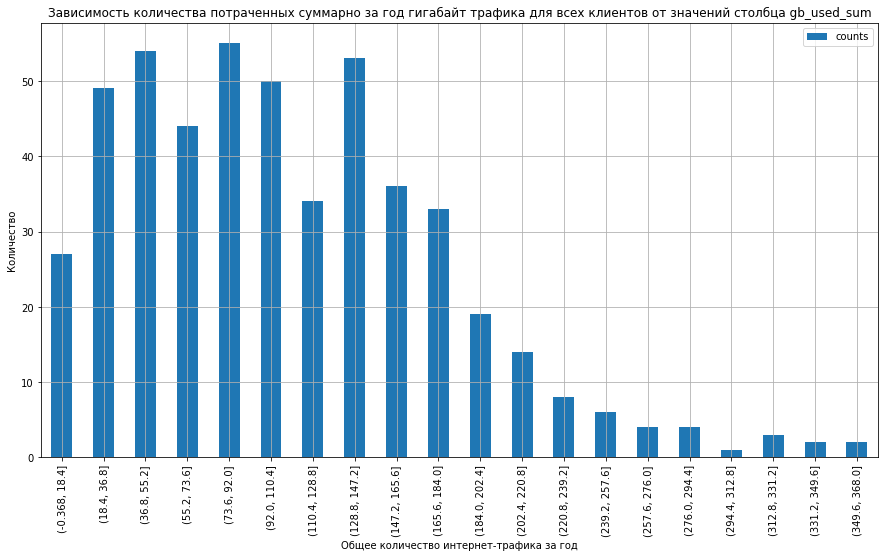

In [79]:
pandas_bar_plot(20, 'gb_used_sum', 1, 'потраченных суммарно за год гигабайт трафика для всех клиентов', data_users)

Среднее количество потраченных за год гигабайт трафика для всех клиентов - 108, стандартное отклонение - 69, медиана - 99, дисперсия - 4739

Дисперсия: 3456.7112239050357


gb_used_sum
count   350.000000
mean    101.337143
std      58.793803
min      11.000000
25%      51.250000
50%      96.000000
75%     141.750000
max     265.000000

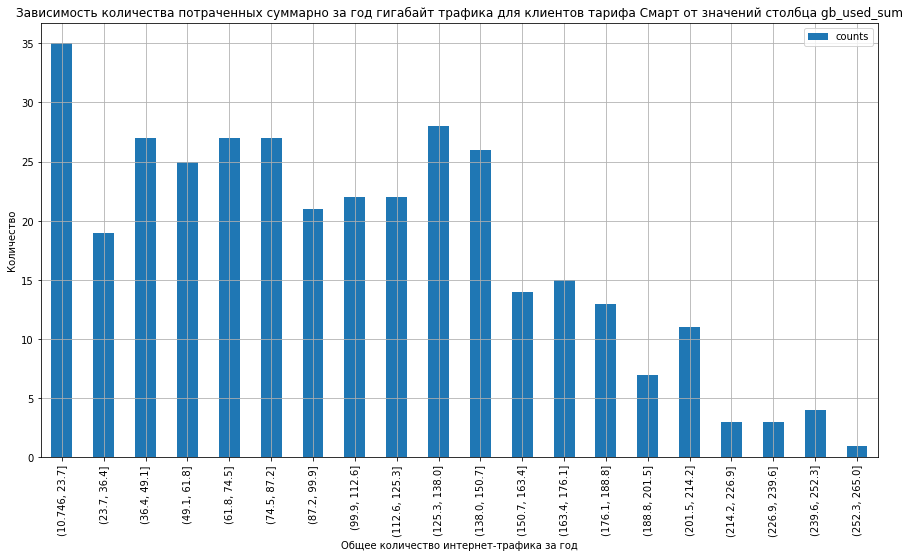

In [80]:
pandas_bar_plot(20, 'gb_used_sum', 1, 'потраченных суммарно за год гигабайт трафика для клиентов тарифа Смарт', data_users[data_users['tariff'] == 'smart'])

Среднее количество потраченных за год гигабайт трафика для клиентов тарифа Смарт - 101, стандартное отклонение - 59, медиана - 96, дисперсия - 3456

Дисперсия: 7351.18293804008


gb_used_sum
count   148.000000
mean    127.027027
std      85.739040
min       0.000000
25%      60.500000
50%     105.500000
75%     171.250000
max     368.000000

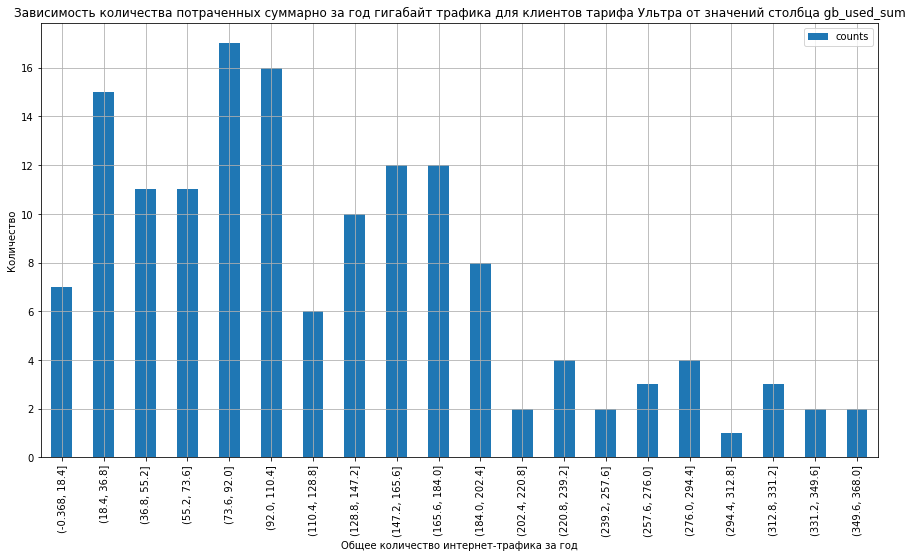

In [81]:
pandas_bar_plot(20, 'gb_used_sum', 1, 'потраченных суммарно за год гигабайт трафика для клиентов тарифа Ультра', data_users[data_users['tariff'] == 'ultra'])

Среднее количество потраченных в месяц гигабайт трафика за год для клиентов тарифа Ультра - 127, стандартное отклонение - 86, медиана - 105, дисперсия - 7351

Дисперсия: 4423138.643107642


duration_sum
count    498.000000
mean    2912.251004
std     2103.125922
min        0.000000
25%     1245.500000
50%     2455.500000
75%     4210.750000
max    12973.000000

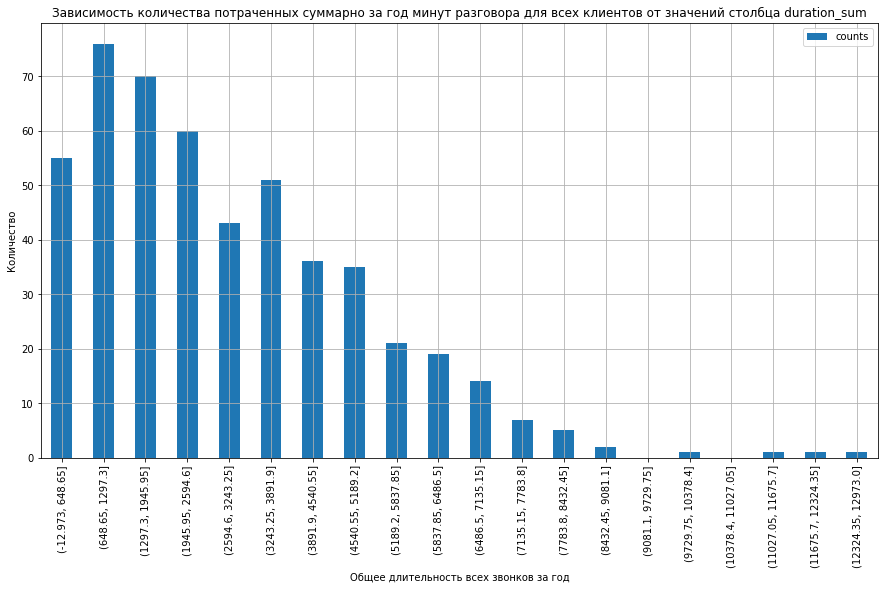

In [82]:
pandas_bar_plot(20, 'duration_sum', 1, 'потраченных суммарно за год минут разговора для всех клиентов', data_users)

Среднее количество потраченных за год минут разговора для всех клиентов - 2912, стандартное отклонение - 2103, медиана - 2455, дисперсия - 4423138

Дисперсия: 3054031.048063855


duration_sum
count    350.000000
mean    2661.648571
std     1747.578624
min        0.000000
25%     1290.750000
50%     2302.500000
75%     3808.000000
max     8543.000000

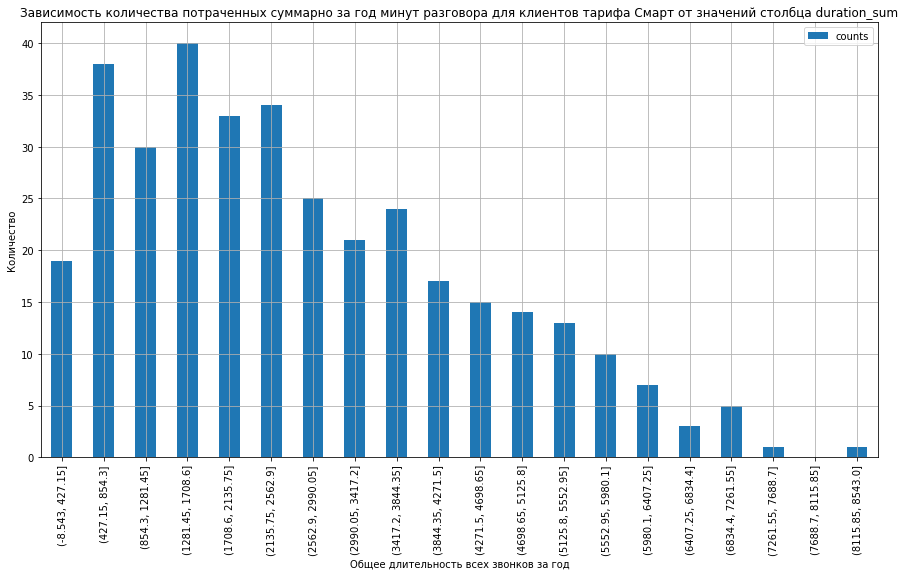

In [83]:
pandas_bar_plot(20, 'duration_sum', 1, 'потраченных суммарно за год минут разговора для клиентов тарифа Смарт', data_users[data_users['tariff'] == 'smart'])

Среднее количество потраченных за год минут разговора для клиентов тарифа Смарт - 2661, стандартное отклонение - 1747, медиана - 2302, дисперсия - 3054031

Дисперсия: 7200554.28755286


duration_sum
count    148.000000
mean    3504.891892
std     2683.384856
min        0.000000
25%     1152.750000
50%     3175.500000
75%     5011.500000
max    12973.000000

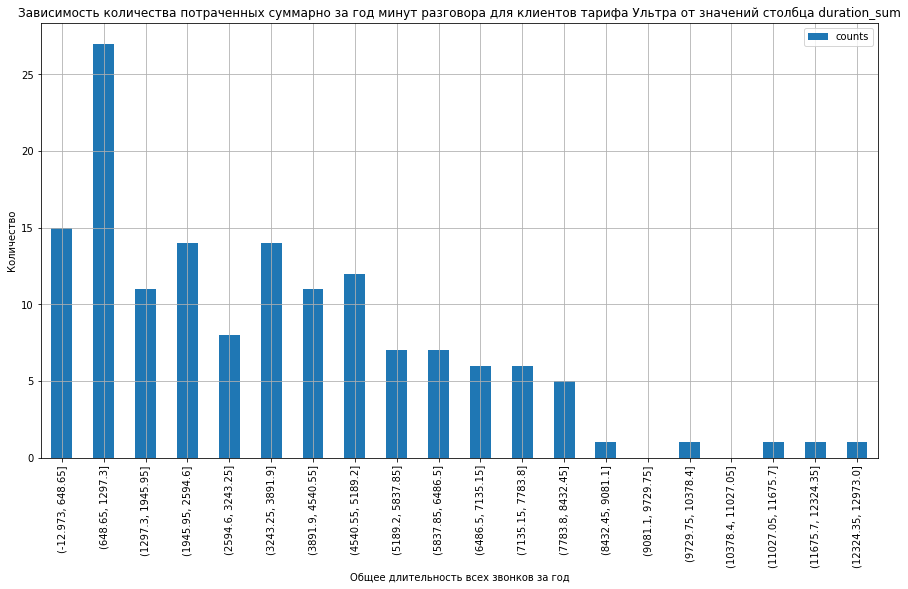

In [84]:
pandas_bar_plot(20, 'duration_sum', 1, 'потраченных суммарно за год минут разговора для клиентов тарифа Ультра', data_users[data_users['tariff'] == 'ultra'])

Среднее количество потраченных в месяц минут разговора за год для клиентов тарифа Ультра - 3504, стандартное отклонение - 2683, медиана - 3175, дисперсия - 7200554

Дисперсия: 71533.12105811616


message_sum
count   500.000000
mean    246.072000
std     267.456765
min       0.000000
25%      42.000000
50%     164.500000
75%     370.000000
max    1463.000000

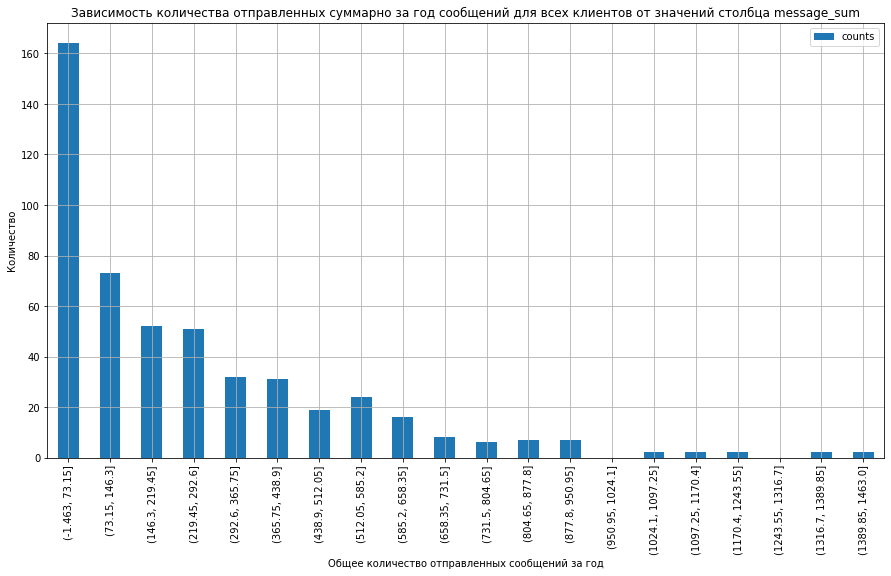

In [85]:
pandas_bar_plot(20, 'message_sum', 1, 'отправленных суммарно за год сообщений для всех клиентов', data_users)

Среднее количество отправленных суммарно за год сообщений для всех клиентов - 246, стандартное отклонение - 267, медиана - 164, дисперсия - 71533

Дисперсия: 49844.76856328853


message_sum
count   351.000000
mean    212.002849
std     223.259420
min       0.000000
25%      38.500000
50%     138.000000
75%     324.000000
max    1092.000000

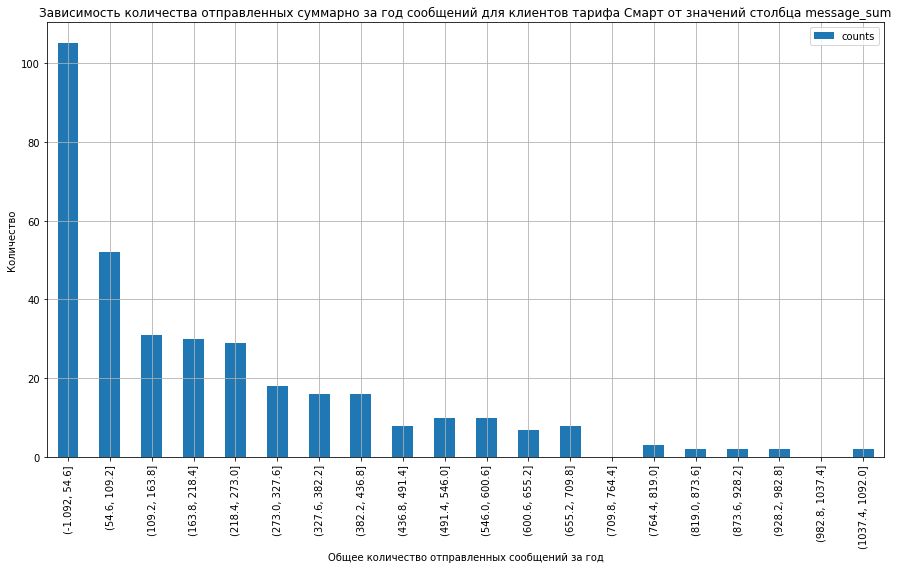

In [86]:
pandas_bar_plot(20, 'message_sum', 1, 'отправленных суммарно за год сообщений для клиентов тарифа Смарт', data_users[data_users['tariff'] == 'smart'])

Среднее количество отправленных суммарно за год сообщений для клиентов тарифа Смарт - 212, стандартное отклонение - 223, медиана - 138, дисперсия - 49844

Дисперсия: 114069.03301287873


message_sum
count   149.000000
mean    326.328859
std     337.741074
min       0.000000
25%      54.000000
50%     250.000000
75%     460.000000
max    1463.000000

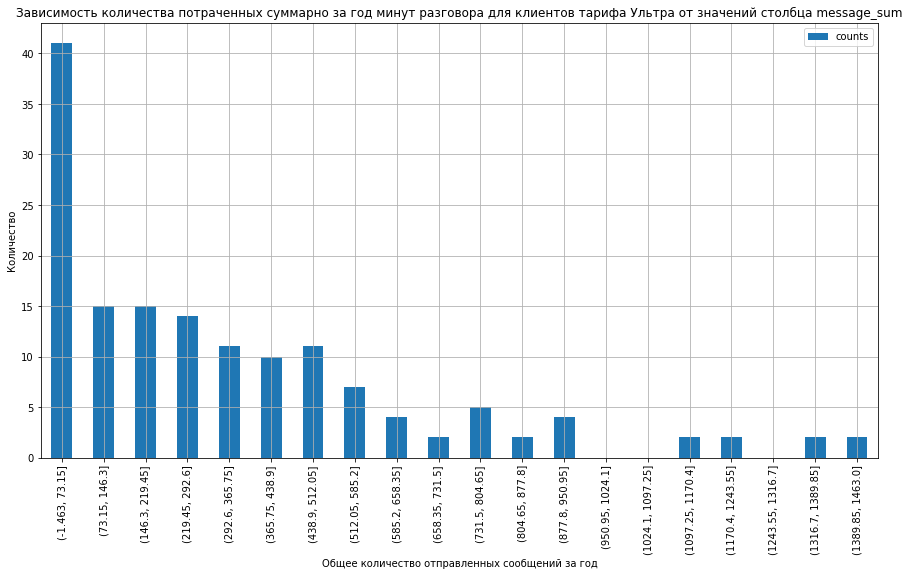

In [87]:
pandas_bar_plot(20, 'message_sum', 1, 'потраченных суммарно за год минут разговора для клиентов тарифа Ультра', data_users[data_users['tariff'] == 'ultra'])

Среднее количество отправленных суммарно за год сообщений за год для клиентов тарифа Ультра - 326, стандартное отклонение - 337, медиана - 250, дисперсия - 114069

В целом можно отметить, что пользователи тарифа Ультра в отличие от пользователей тарифа Смарт, помимо того что больше тратят и больше пользуются услугами связи, в своей совокупности по всем параметрам меньше напоминают нормальное распределение - среди клиентов гораздо меньше однородности. Возможно, это говорит о том, что разделение по тарифами не делит людей на богатых и бедных или на часто и редко пользующихся услугами связи. Эта связь сложнее.

### Проверка некоторых гипотез

Как нам известно, мы имеем выборку из 500 клиентов Мегалайна. О методах получения выборки мы ничего не знаем, но будем надеяться, что она адекватно отражает генеральную совокупность из всех клиентов компании Мегалайн.

Нам нужно проверить две гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Исходя из этого, нас интересуют двусторонние гипотезы. Более точные различия о том, что какое-то из средних больше, проведут другие люди на других выборках и с использованием односторонних гипотез. Или я сам и сделаю, если ревьюер скажет:)

#### Траты клиентов разных тарифных планов

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.

Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Что имеем из данных: 
* выборку из 2272 элементов - траты различных пользователей, использующих тариф Смарт, в различные месяцы использования
* выборку из 1003 элементов - траты различных пользователей, использующих тариф Ультра, в различные месяцы использования

Генеральные совокупности из клиентов различных тарифов независимы - мы проверили, что один и тот же клиент не пользовался двумя тарифами в разное время (только если они не меняли паспортные данные). Как следствие мы можем использовать t-тест.

p-value выберем 0.01

In [88]:
smart_clients = data_users[data_users['tariff'] == 'smart']['total_cost'].explode().to_list()
ultra_clients = data_users[data_users['tariff'] == 'ultra']['total_cost'].explode().to_list()

alpha = .01

results = st.ttest_ind(smart_clients, ultra_clients, equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.847152282815517e-274
Отвергаем нулевую гипотезу


#### Траты клиентов Москвы и обитателей других регионов

Нулевая гипотеза: средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов одинакова.

Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Что имеем из данных: 
* выборку из 621 элементов - траты различных пользователей из Москвы, использующих услуги Мегалайна в различные месяцы 
* выборку из 2654 элементов - траты различных пользователей НЕ из Москвы, использующих услуги Мегалайна в различные месяцы 

Генеральные совокупности из клиентов различных тарифов независимы. Как следствие мы можем использовать t-тест.

p-value выберем 0.01, как и в предыдущем случае.

In [89]:
moscow_clients = data_users[data_users['city'] == 'МОСКВА']['total_cost'].explode().to_list()
zamkadye_clients = data_users[data_users['city'] != 'МОСКВА']['total_cost'].explode().to_list()

alpha = .01

results = st.ttest_ind(moscow_clients, zamkadye_clients, equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.6601869505495059
Не получилось отвергнуть нулевую гипотезу


### Вывод

Мы посчитали различные метрики для данных клиентов, которые нам предоставили:
* количество сделанных звонков и израсходованных минут разговора по месяцам
* количество отправленных сообщений по месяцам
* объем израсходованного интернет-трафика по месяцам
* помесячную выручку с каждого пользователя

Для всех этих метрик были построены графики и посчитаны средние, медианы и среднеквадратичные отклонения. Не вдаваясь в отдельные числа, можно сделать следующие выводы:

* пользователи тарифа Ультра практически всегда укладываются в услуги, предоставляемые их тарифом. Пользователи же тарифа Смарт, напротив, часто любят превысить лимиты (больше чем в половине случаев)
* пользователи тарифа Ультра отправляют сообщения в среднем чаще (в полтора раза) и с бОльшим разбросом; распределение никак не похоже на пуассоновское из-за того, что многие клиенты не отправляют сообщения
* распределения по количеству израсходованного трафика, по количеству звонков и по длительности звонков в месяц напоминают пуассоновское. В распределениях пользователей тарифа Ультра толще хвосты, максимум (весьма ожидаемо) правее, а распределение израсходованного трафика имеет "дыры" и гораздо меньше похоже на пуассоновское

В целом можно отметить, что пользователи тарифа Ультра в отличие от пользователей тарифа Смарт, помимо того что больше тратят и больше пользуются услугами связи, в своей совокупности по всем параметрам меньше напоминают нормальное распределение - среди клиентов гораздо меньше однородности. Возможно, это говорит о том, что разделение по тарифами не делит людей на богатых и бедных или на часто и редко пользующихся услугами связи. Эта связь сложнее.

Также мы проверили следующие гипотезы:

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
Нулевая гипотеза "средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова" была отвергнута в пользу альтернативной гипотезы "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается" с p-value 1.03e-304 (пороговое значение 0.01)

* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Нулевая гипотеза "средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов одинакова" не была отвергнута (p-value 0.41, пороговое значение 0.01)

## Общий вывод

В этом пункте мы опишем проделанную нами работу и опишем полученные результаты.

Мы посмотрели на данные. Всего в нашем распоряжении было пять таблиц, три из которых (данные по звонкам, сообщениям и интернет-соединениям) мы объединили в одну. Оставшиеся две (данные пользователей и данные по тарифами) было решено оставить и использовать как промежуточные во избежание повторений данных в таблице.

Каждый столбец в двух из трех таблиц (таблица по данным тарифов состояла из полутора десятков значений, которые легко просматривались глазами) был проверен на пропуски и наличие логических ошибок (например, порядок дат регистрации, дат пользований конкретной услугой и дат окончания пользования тарифом). Данные, предоставленные нам, чистые и аккуратные. Нигде нет пропусков, не имеющих под собой логического объяснения. Распределения всех величин имеют пуассоновское распределение там, где это должно быть. Ошибок и коллизий найдено не было.

После этого мы посчитали различные метрики для данных клиентов, которые нам предоставили:
* количество сделанных звонков и израсходованных минут разговора по месяцам
* количество отправленных сообщений по месяцам
* объем израсходованного интернет-трафика по месяцам
* помесячную выручку с каждого пользователя

Для всех этих метрик были построены графики и посчитаны средние, медианы и среднеквадратичные отклонения. Не вдаваясь в отдельные числа, можно сделать следующие выводы:

* пользователи тарифа Ультра практически всегда укладываются в услуги, предоставляемые их тарифом. Пользователи же тарифа Смарт, напротив, часто любят превысить лимиты (больше чем в половине случаев)
* пользователи тарифа Ультра отправляют сообщения в среднем чаще (в полтора раза) и с бОльшим разбросом; распределение никак не похоже на пуассоновское из-за того, что многие клиенты не отправляют сообщения
* распределения по количеству израсходованного трафика, по количеству звонков и по длительности звонков в месяц напоминают пуассоновское. В распределениях пользователей тарифа Ультра толще хвосты, максимум (весьма ожидаемо) правее, а распределение израсходованного трафика имеет "дыры" и гораздо меньше похоже на пуассоновское

В целом можно отметить, что пользователи тарифа Ультра в отличие от пользователей тарифа Смарт, помимо того что больше тратят и больше пользуются услугами связи, в своей совокупности по всем параметрам меньше напоминают нормальное распределение - среди клиентов гораздо меньше однородности. Возможно, это говорит о том, что разделение по тарифами не делит людей на богатых и бедных или на часто и редко пользующихся услугами связи. Эта связь сложнее.

Также мы проверили следующие гипотезы:

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
Нулевая гипотеза "средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова" была отвергнута в пользу альтернативной гипотезы "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается" с p-value 1.03e-304 (пороговое значение 0.01)

* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Нулевая гипотеза "средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов одинакова" не была отвергнута (p-value 0.41, пороговое значение 0.01)